In [47]:
import snntorch as snn
import torch
import torch.nn as nn
from snntorch import spikeplot as splt
from torch.utils.data import DataLoader
# from torchvision import datasets, transforms
import numpy as np
import itertools
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import network
import torch.optim as optim
import os
from PIL import Image
import torchvision.transforms.functional as TF
import cv2
import pandas as pd
import time
import data as dt
from kalman import ThrowKF, RollKF, CA3DKalmanFilter_ZeroXY
from simulator import Camera, Field, BALL_RADIUS
from tqdm import tqdm
import logging

# os.environ["CUDA_LAUNCH_BLOCKING"] = "1" # for debugging on GPU
%load_ext autoreload
%autoreload 2

device = "cuda" if torch.cuda.is_available() else "cpu"
device

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


'cuda'

In [39]:
dataset_path = 'dataset_python_sim'
accumulation_time = 10 # ms
quantization = 8
batch_size = 4
dataset_type = "all"
goal_type = "all" # "goal", "throw", "roll", "all"
labels = ['x_cam', 'y_cam', 'R_cam']#, 'in_fov']
trainset = dt.Tracking3DVideoDataset(dataset_path, accumulation_time, quantization = 8, label_quantization=1, split='train', dataset_type=dataset_type, goal_type=goal_type, labels=labels)
testset = dt.Tracking3DVideoDataset(dataset_path, accumulation_time, quantization = quantization, split='test', dataset_type=dataset_type, goal_type=goal_type, labels=labels)
validationset = dt.Tracking3DVideoDataset(dataset_path, accumulation_time, quantization = quantization, split='val', dataset_type=dataset_type, goal_type=goal_type, labels=labels)
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=False, num_workers=0, collate_fn=trainset.collate_fn)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=0, collate_fn=testset.collate_fn)
valid_loader = DataLoader(validationset, batch_size=batch_size, shuffle=False, num_workers=0, collate_fn=validationset.collate_fn)

new_positions_csv = f'dataset_python_sim/positions_in_fov_{accumulation_time}ms.csv'
trainset_in = dt.Tracking3DVideoDataset(dataset_path, accumulation_time, positions_csv=new_positions_csv, quantization = quantization, split='train', dataset_type=dataset_type, goal_type=goal_type)
testset_in = dt.Tracking3DVideoDataset(dataset_path, accumulation_time, positions_csv=new_positions_csv, quantization = quantization, split='test', dataset_type=dataset_type, goal_type=goal_type)
validationset_in = dt.Tracking3DVideoDataset(dataset_path, accumulation_time, positions_csv=new_positions_csv, quantization = quantization, split='val', dataset_type=dataset_type, goal_type=goal_type)
trainloader_in = DataLoader(trainset_in, batch_size=batch_size, shuffle=False, num_workers=0, collate_fn=trainset_in.collate_fn)
testloader_in = DataLoader(testset_in, batch_size=batch_size, shuffle=False, num_workers=0, collate_fn=testset_in.collate_fn)
valid_loader_in = DataLoader(validationset_in, batch_size=batch_size, shuffle=False, num_workers=0, collate_fn=validationset_in.collate_fn)

labels_world = ['x', 'y', 'z']
trainset_world = dt.Tracking3DVideoDataset(dataset_path, accumulation_time, quantization = 32, label_quantization=1, split='train', dataset_type=dataset_type, goal_type=goal_type, labels=labels_world)
testset_world = dt.Tracking3DVideoDataset(dataset_path, accumulation_time, quantization = 32, label_quantization=1, split='test', dataset_type=dataset_type, goal_type=goal_type, labels=labels_world)
validationset_world = dt.Tracking3DVideoDataset(dataset_path, accumulation_time, quantization = 32, label_quantization=1, split='val', dataset_type=dataset_type, goal_type=goal_type, labels=labels_world)
trainloader_world = DataLoader(trainset_world, batch_size=batch_size, shuffle=False, num_workers=0, collate_fn=trainset_world.collate_fn)
testloader_world = DataLoader(testset_world, batch_size=batch_size, shuffle=False, num_workers=0, collate_fn=testset_world.collate_fn)
valid_loader_world = DataLoader(validationset_world, batch_size=batch_size, shuffle=False, num_workers=0, collate_fn=validationset_world.collate_fn)

Loading dataset from dataset_python_sim with accumulation time 10ms
Loaded 21531 rows from dataset_python_sim\positions_10ms.csv
Found 156 sequences in dataset_python_sim\positions_10ms.csv
Shape of the images: torch.Size([2, 90, 160])
Number of label fields: 3
Split sizes: train=109, val=23, test=24, total=156
Final dataset split='train' size: 109

Loading dataset from dataset_python_sim with accumulation time 10ms
Loaded 21531 rows from dataset_python_sim\positions_10ms.csv
Found 156 sequences in dataset_python_sim\positions_10ms.csv
Shape of the images: torch.Size([2, 90, 160])
Number of label fields: 3
Split sizes: train=109, val=23, test=24, total=156
Final dataset split='test' size: 24

Loading dataset from dataset_python_sim with accumulation time 10ms
Loaded 21531 rows from dataset_python_sim\positions_10ms.csv
Found 156 sequences in dataset_python_sim\positions_10ms.csv
Shape of the images: torch.Size([2, 90, 160])
Number of label fields: 3
Split sizes: train=109, val=23, test

In [48]:
dataset_path = 'dataset_python_sim2'
accumulation_time = 10 # ms
quantization = 8
batch_size = 4
dataset_type = "all"
goal_type = "all" # "goal", "throw", "roll", "all"
labels = ['x_cam', 'y_cam', 'R_cam']#, 'in_fov']
dataset_all = dt.Tracking3DVideoDataset(dataset_path, accumulation_time, quantization = quantization, split='all', dataset_type=dataset_type, goal_type=goal_type, labels=labels)
datloader_all = DataLoader(dataset_all, batch_size=batch_size, shuffle=False, num_workers=0, collate_fn=dataset_all.collate_fn)

new_positions_csv = f'dataset_python_sim2/positions_in_fov_{accumulation_time}ms.csv'
dataset_in = dt.Tracking3DVideoDataset(dataset_path, accumulation_time, positions_csv=new_positions_csv, quantization = quantization, split='all', dataset_type=dataset_type, goal_type=goal_type)
dataloader_in = DataLoader(dataset_in, batch_size=batch_size, shuffle=False, num_workers=0, collate_fn=dataset_in.collate_fn)

labels_world = ['x', 'y', 'z']
dataset_world = dt.Tracking3DVideoDataset(dataset_path, accumulation_time, quantization = 32, label_quantization=1, split='all', dataset_type=dataset_type, goal_type=goal_type, labels=labels_world)
dataloader_world = DataLoader(dataset_world, batch_size=batch_size, shuffle=False, num_workers=0, collate_fn=dataset_world.collate_fn)


Loading dataset from dataset_python_sim2 with accumulation time 10ms
Loaded 12657 rows from dataset_python_sim2\positions_10ms.csv
Found 87 sequences in dataset_python_sim2\positions_10ms.csv
Shape of the images: torch.Size([2, 90, 160])
Number of label fields: 3
Final dataset split='all' size: 87

Loading dataset from dataset_python_sim2 with accumulation time 10ms
Loaded 12254 rows from dataset_python_sim2/positions_in_fov_10ms.csv
Found 87 sequences in dataset_python_sim2/positions_in_fov_10ms.csv
Shape of the images: torch.Size([2, 90, 160])
Number of label fields: 3
Final dataset split='all' size: 87

Loading dataset from dataset_python_sim2 with accumulation time 10ms
Loaded 12657 rows from dataset_python_sim2\positions_10ms.csv
Found 87 sequences in dataset_python_sim2\positions_10ms.csv
Shape of the images: torch.Size([2, 22, 40])
Number of label fields: 3
Final dataset split='all' size: 87



In [3]:
video, labels, length = dataset_in.__getitemtr__(7)
gen = dt.image_gen_for_video(video, labels)

720 1280
max tensor(1.)
min tensor(0.)
Label:  tensor([390.1238, 135.3571,  60.0714])


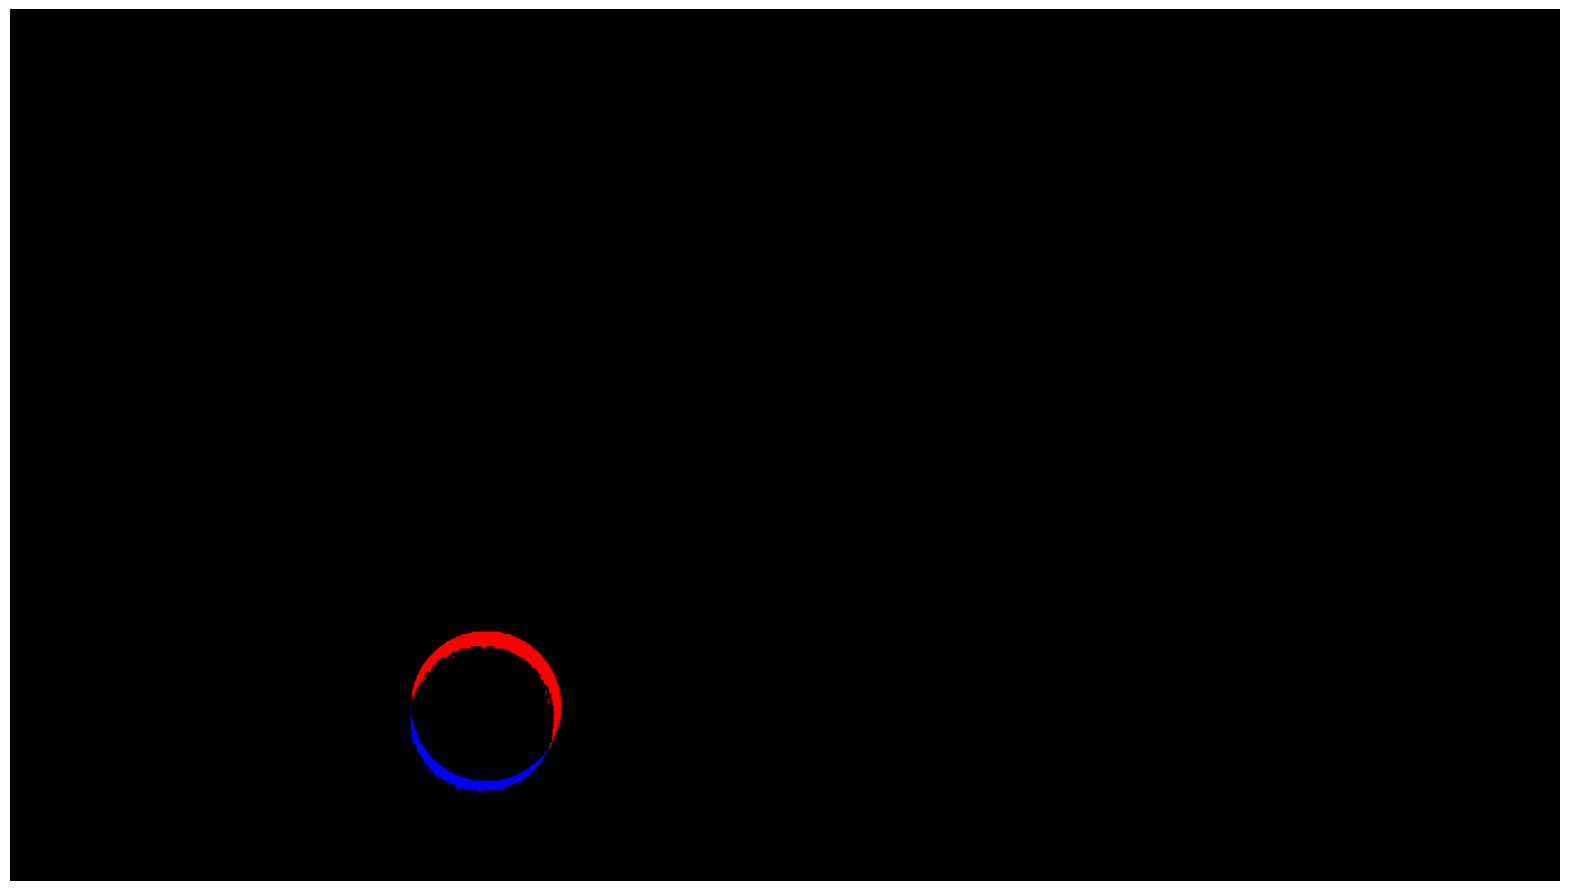

In [5]:
dt.show_next_img(gen, False, just_image=True)

In [42]:
# Helper functions

# Convert to X,Y,Z  coordinates
W = 14.0      # field width (m)
L = 11.0       # field length (m)

FIELD = Field(W, L, 2.4, 1)


# CameraLeft
cam_x = -0.05994 + 7
cam_y = -11 + 0.12 + 0.025 + 11
cam_z = 0.55

camera_pos = np.array([cam_x, cam_y, cam_z])          # Camera position in world space

fps = 200

# ---------------------
# Define camera parameters for the pinhole model
# ---------------------      
# Where the camera is looking (center of field)
camera_target = np.array([FIELD.center[0], FIELD.center[1], camera_pos[2]])        # Where the camera is looking (center of field) It would be good to transform this into an angle and assume verticality
orientation = Camera.get_orientation(camera_pos, camera_target)
img_width, img_height = 1280, 720               # Image resolution (in pixels)
focal_length = 0.008                             # Focal length in meters

CAMERA = Camera(camera_pos, orientation, focal_length, img_width, img_height, fps = fps)

def project_to_world(preds, dataset, labels=None, camera = CAMERA):
    """
    Projects the predicted and ground truth ball positions from camera coordinates to world coordinates.
    
    Args:
        preds (torch.Tensor): Predicted ball positions in camera coordinates.
        labels (torch.Tensor): Ground truth ball positions in camera coordinates.
        dataset (Tracking3DVideoDataset): The dataset containing quantization information.
        
    Returns:
        tuple: Projected predicted and ground truth positions in world coordinates.
    """
    pred_pos = camera.project_ball_camera_to_world(preds*dataset.quantization, False)
    if labels is not None:
        truth_pos = camera.project_ball_camera_to_world(labels*dataset.quantization, False).numpy()
        return pred_pos, truth_pos
    else:
        return pred_pos, None

def project_to_camera(world_pos, dataset, camera = CAMERA):
    """
    Projects the world coordinates to camera coordinates.
    
    Args:
        world_pos (np.ndarray): Ball positions in world coordinates.
        dataset (Tracking3DVideoDataset): The dataset containing quantization information.
        
    Returns:
        np.ndarray: Projected ball positions in camera coordinates.
    """
    uvs, depths = camera.project_point(world_pos)
    radii = camera.get_radius_pixels(BALL_RADIUS, depths)

    q = dataset.label_quantization
    # ensure arrays
    u = (uvs[..., 0] // q).astype(int)
    v = (uvs[..., 1] // q).astype(int)
    r = (radii     // q).astype(int)

    # stack into (N,3) or (3,) if single
    out = np.stack([u, v, r], axis=-1)
    return out
    
delta_t = 0.01
process_var_vel_xy = 0.1
process_var_vel_z  = 0.1
meas_var_pos       = 0.5

def kalman_loop_out_of_fov(kf, pred_pos, truth_pos, last_measurement_ts = None):
    positions = []
    # Initialize Kalman filter with the first measurement
    # kf.predict()
    if last_measurement_ts is None: last_measurement_ts = len(pred_pos)
    kf.update(truth_pos[0])
    # Predict/update the next states
    for i, z in enumerate(pred_pos[1:], start=1):
        kf.predict()
        world_pos = kf.x.flatten()[:3]
        (x, y), depth = CAMERA.project_point(world_pos)
        if x < 0 or x > CAMERA.img_width or y < 0 or y > CAMERA.img_height:
            print(f"Ball went out of the FOV at timestep {i}, skipping update")
            print(f"Predicted position: {world_pos}, projected to image coordinates: ({x}, {y})")
            print(f"Real position: {truth_pos[i]}")
            print(f"Predicted position: {pred_pos[i]}")
            positions[i] = kf.x.flatten()[:3]
            continue
        if i < last_measurement_ts: kf.update(z)
        positions.append(kf.x.flatten()[:3])
        if kf.x.flatten()[:3][1] < 0: break # Stop when the ball is in the goal
    return kf, positions

def kalman_loop_in_fov(kf, pred_pos, truth_pos, last_measurement_ts = None, controls = None):
    positions = []
    # Initialize Kalman filter with the first measurement
    # kf.predict()
    if last_measurement_ts is None: last_measurement_ts = len(pred_pos)
    kf.update(truth_pos[0])
    # Predict/update the next states
    for i, z in enumerate(pred_pos[1:], start=1):
        if controls is not None:
            kf.predict(controls)
        else:
            kf.predict()
        if i < last_measurement_ts: kf.update(z)
        if controls is not None:
            position = kf.fused_state()[0][:3]
        else:
            position = kf.x.flatten()[:3]
        positions.append(position)
        if position[1] < 0: break # Stop when the ball is in the goal
    return kf, positions

def predict_until_goal(kf, positions, controls = None, truth = False):
    initial_n_positions = len(positions)
    if controls is not None:
        position = kf.fused_state()[0][:3]
    else:
        position = kf.x.flatten()[:3]
    while position[1] > 0: # The goal is at y=0
        if controls is not None:
            kf.predict(controls)
            position = kf.fused_state()[0][:3]
        else:
            kf.predict()
            position = kf.x.flatten()[:3]
        positions.append(position)
        if len(positions) > initial_n_positions + 1000:
            # print("Warning, many iterations. Maybe the ball is not going to the goal. ", "Ground truth" if truth else "Predicted")
            return kf, None
    return kf, positions

def predict_until_time(kf, positions, timesteps, controls = None):
    for ts in range(timesteps):
        if controls is not None:
            kf.predict(controls)
            position = kf.fused_state()[0][:3]
        else:
            kf.predict()
            position = kf.x.flatten()[:3]
        positions.append(position)
    return kf, positions


def kf_positions_for_idx(idx, dataset, all_preds, world_dataset, KFClass, cutoff, delta_t=0.01, process_var_acc=0.01, meas_var_pos=0.5): 
    tr = dataset.__gettr__(idx)
    preds = all_preds[idx]
    positions, truth_positions = kf_positions_for_tr(tr, dataset, preds, world_dataset, KFClass, cutoff, delta_t, process_var_acc, meas_var_pos)

    return np.array(positions), np.array(truth_positions)

def kf_positions_for_tr(tr, dataset, preds, world_dataset, KFClass, cutoff, delta_t=0.01, process_var_acc=0.01, meas_var_pos=0.5, print_graph=False): 
    # Get predictions
    _, labels, _ = dataset.__getitemtr__(tr)
    labels = labels.transpose(0, 1)

    if type(preds) is not np.ndarray:
        idx = dataset.__getidx__(tr)
        print(f"Using idx {idx} for trajectory {tr}")
        preds = preds[idx]

    # Get ground truth
    _, gt_labels, _ = world_dataset.__getitemtr__(tr)
    gt_labels = gt_labels.cpu().numpy()
    pred_pos, _ = project_to_world(preds, dataset)

    kf_preds = KFClass(delta_t, process_var_acc, meas_var_pos)
    kf_truth = KFClass(delta_t, 0.000001, 0.000001)

    last_measurement_ts = int(cutoff/delta_t)

    kf_preds, positions = kalman_loop_in_fov(kf_preds, pred_pos, gt_labels, last_measurement_ts)
    kf_truth, truth_positions = kalman_loop_in_fov(kf_truth, gt_labels, gt_labels)

    kf_preds, positions = predict_until_goal(kf_preds, positions, tr)
    kf_truth, truth_positions = predict_until_goal(kf_truth, truth_positions, tr)

    if print_graph:
        print_kf_graph(np.array(positions), np.array(truth_positions), pred_pos, gt_labels, last_measurement_ts)
        
    del kf_preds, kf_truth, preds
    return np.array(positions), np.array(truth_positions)

def print_kf_graph(positions, truth_positions, pred_pos, truth_labels, last_measurement_ts = None, ground_truth = False):
    if last_measurement_ts is None or last_measurement_ts > len(pred_pos): last_measurement_ts = len(pred_pos)
    fig, axs = plt.subplots(3, 1, figsize=(10, 8))
    last_pred_ts = len(positions)
    for i, label in enumerate(['X', 'Y', 'Z']):
        axs[i].plot(positions[:, i], label='Kalman Filter', color='red')
        axs[i].plot(pred_pos[:last_measurement_ts, i], label='Predictions', color='blue')
        if ground_truth:
            if len(truth_labels) > last_pred_ts and positions[-1, 1] > 0.1:
                # axs[i].plot(truth_positions[:last_pred_ts, i], label='Ground Truth', color='green')
                axs[i].plot(truth_labels[:last_pred_ts, i], label='Ground Truth Labels', color='green')
            else:
                axs[i].plot(truth_positions[:, i], label='Ground Truth', color='green')
            # axs[i].plot(truth_labels[:last_pred_ts, i], label='Ground Truth Labels', color='orange')
        axs[i].axvline(x=last_measurement_ts, color='grey', linestyle='--', label='Last Measurement')
        axs[i].set_title(f'{label} Position')
        axs[i].legend()
        axs[i].grid(True)
    plt.tight_layout()
    plt.show()


z_floor = 0.1
margin = 0.15 # margin for hysteresis
T_down  = z_floor - margin
T_up    = z_floor + margin

def majority_regime(pred_pos, last_measurement_ts = None, delta_t=0.01,
                    pv_xy=0.1, pv_z=0.1, mv=0.5):
    """
    Run the regime‐switching loop on one sequence of z‐positions `pred_pos`
    (shape N×3 or N×:z-index). Return the majority regime: "roll" or "throw".
    """
    roll_kf   = RollKF(delta_t, pv_xy, mv)
    throw_kf = ThrowKF(delta_t, pv_z,  mv)

    regime = 'roll'
    votes = []
    positions_throw = []
    positions_roll = []

    if last_measurement_ts is None or last_measurement_ts > len(pred_pos): last_measurement_ts = len(pred_pos)

    for i, meas in enumerate(pred_pos):
        # predict
        if i >= last_measurement_ts: break
        
        roll_kf.predict()
        throw_kf.predict()
        # if regime == 'flight':
        #     x_pred = flight_kf.x
        # else:
        #     x_pred = roll_kf.x


        # update

        z_meas  = meas[2]
        # vz_pred = x_pred[5,0]
        throw_kf.update(meas)
        roll_kf.update(meas)

        # hysteresis
        if regime == 'throw' and z_meas < T_down:
            regime = 'roll'
        elif regime == 'roll' and z_meas > T_up:
            regime = 'throw'

        votes.append(regime)
        positions_throw.append(throw_kf.x.flatten()[:3])
        positions_roll.append(roll_kf.x.flatten()[:3])
        
        # print(z_pred, regime)

    # majority vote
    rolls   = votes.count('roll')
    throws = votes.count('throw')
    # print(f"Votes: {rolls} rolls, {throws} throws")
    return (roll_kf, positions_roll, 'roll') if rolls > throws else (throw_kf, positions_throw, 'throw')

delta_t = 0.01
process_var_vel_xy = 0.1
process_var_vel_z  = 0.1
meas_var_pos       = 0.9

def evaluate_kf(dataloader, model, device, KFClass = None, cutoff_time = None, cutoff_distance = None, time_pred = None, all_preds=None, check_result='goal'):
    """
    Evaluate Kalman Filter positions for all videos in the dataloader.
    Returns an array of differences between predicted and ground truth positions, and a confusion matrix.
    Trajectories that go "out" of the goal are skipped in the differences calculation.
    dataset = dataloader.dataset
    """

    if cutoff_time is None and cutoff_distance is None:
        print("No cutoff specified, looking at all positions.")
    elif cutoff_time is not None and cutoff_distance is not None:
        raise ValueError("Specify either cutoff_time or cutoff_distance, not both.")
    elif cutoff_time is not None:
        print(f"Using cutoff time: {cutoff_time} seconds.")
        cutoff_type = 'time'
    elif cutoff_distance is not None:
        print(f"Using cutoff distance: {cutoff_distance} meters.")
        cutoff_type = 'distance'
    
    if check_result == 'time':
        if time_pred is None:
            raise ValueError("If check_result is 'time', time_pred must be specified.")
        elif time_pred is not None:
            print(f"Using time prediction: {time_pred} seconds.")
    elif check_result == 'goal':
        if time_pred is not None:
            print(f"WARNING: time_pred is ignored when check_result is 'goal'.")
        else:
            print("Using goal prediction.")
    else:
        raise ValueError("check_result must be either 'goal' or 'time'.")
    

    dataset = dataloader.dataset
    N = len(dataset)
    diffs = []

    # Prepare confusion matrix
    classes = ["in", "out"]
    conf_mat = np.zeros((2,2), dtype=int)

    if all_preds is None: all_preds = network.get_preds_all_videos(model, dataloader, device=device, num_steps=model.training_params['num_steps'])
    for idx in tqdm(range(N), desc="Evaluating Kalman Filter"):
        _, labels, _ = dataset.__getitem__(idx)
        tr = dataset.__gettr__(idx)
        # Get predictions
        preds = all_preds[idx]
        labels = labels.transpose(0, 1)

        # Get ground truth
        _, gt_labels, _ = dataset_world.__getitemtr__(tr)
        gt_labels = gt_labels.cpu().numpy()
        pred_pos, _ = project_to_world(preds, dataset)
        N = len(pred_pos)

        if cutoff_type == "time":
            last_measurement_ts = int(cutoff_time/delta_t)
            if last_measurement_ts > N:
                # print(f"Skipping trajectory {tr} due to insufficient measurements.")
                continue
        elif cutoff_type == "distance":
            # Calculate the last measurement based on the Y position
            y_positions = gt_labels[:, 1]
            excluded_preds = np.where(y_positions < cutoff_distance)
            # print(y_positions[0])
            # print(len(excluded_preds[0]), N, len(y_positions))
            if len(excluded_preds[0]) == len(y_positions):
                # print(f"Skipping trajectory {tr} due to no measurements within cutoff distance.")
                continue
            elif len(excluded_preds[0]) == 0:
                # print(f"Skipping trajectory {tr} due to not getting to cutoff distance.")
                # continue
                last_measurement_ts = N
            else:
                last_measurement_ts = excluded_preds[0][0]

        # print(f"Last measurement timestamp: {last_measurement_ts}, Total timesteps: {N}")
        
        if KFClass is None:
            kf_preds, kf_pred_positions, pred_regime = majority_regime(pred_pos, last_measurement_ts=last_measurement_ts)

            KFClass = RollKF if pred_regime == 'roll' else ThrowKF
        else:
            kf_preds = KFClass(delta_t, process_var_vel_xy, meas_var_pos)
            kf_preds, kf_pred_positions = kalman_loop_in_fov(kf_preds, pred_pos, gt_labels, last_measurement_ts)
            
        kf_truth = KFClass(delta_t, process_var_vel_xy, meas_var_pos)

        kf_truth, truth_positions = kalman_loop_in_fov(kf_truth, gt_labels, gt_labels, last_measurement_ts)

        # print(f"Predicted positions shape: {len(kf_pred_positions)}")
        # print(f"Ground truth positions shape: {len(truth_positions)}")

        if check_result == 'goal':
            kf_preds, kf_pred_positions = predict_until_goal(kf_preds, kf_pred_positions)
            kf_truth, truth_positions = predict_until_goal(kf_truth, truth_positions)
            if kf_pred_positions is None or truth_positions is None:
                # print(f"Skipping trajectory {tr} due to insufficient measurements for goal prediction.")
                continue
        elif check_result == 'time':
            timesteps_pred = int(time_pred / delta_t)
            # print(f"Predicting until {timesteps_pred} timesteps after the last measurement.")
            # print(f"Last measurement timestamp: {last_measurement_ts}, Total timesteps: {last_measurement_ts + timesteps_pred}")
            if last_measurement_ts + timesteps_pred > len(gt_labels):
                # print(f"Skipping trajectory {tr} due to insufficient measurements for time prediction.")
                continue
            kf_preds, kf_pred_positions = predict_until_time(kf_preds, kf_pred_positions, timesteps_pred)
            kf_truth, truth_positions = predict_until_time(kf_truth, truth_positions, timesteps_pred)
            
        kf_pred_positions = np.array(kf_pred_positions)
        # print(f"Predicted positions shape: {kf_pred_positions.shape}")
        truth_positions = np.array(truth_positions)
        # print(f"Ground truth positions shape: {truth_positions.shape}")
        
        final_prediction = kf_pred_positions[-1]
        final_true_position = truth_positions[-1]


        if check_result == 'goal':
            pred_type, gt_type = get_traj_type(final_prediction, dataset, tr, FIELD)

            # 1) Record confusion for *all* trajectories
            i = classes.index(gt_type)
            j = classes.index(pred_type)
            conf_mat[i, j] += 1

            # if pred_type == 'in' and gt_type == 'in':

            # Here record the results in a 3x3 confusion matrix ("in", "almost_in", "out")

            if pred_type == 'out' or gt_type == 'out':
                continue

        # print(f"Position in goal: {position_in_goal}, Truth in goal: {truth_in_goal}")
        
        # Add the timestamp to the final positions
        final_prediction = np.append(final_prediction, len(kf_pred_positions)*delta_t)
        final_true_position = np.append(final_true_position, len(truth_positions)*delta_t)

        diffs.append([abs(final_prediction[k] - final_true_position[k]) for k in range(len(final_prediction))])
        # diffs.append([final_prediction[k] - final_true_position[k] for k in range(len(final_prediction))])
        # 7) Delete everything large before next iteration
        # del preds, kf_pred_positions, truth_positions
        del final_prediction, final_true_position, pred_pos, gt_labels
        del preds, labels, kf_pred_positions, truth_positions, kf_preds, kf_truth
        torch.cuda.empty_cache()
        # break

    diffs = np.array(diffs, dtype=np.float32)
    # print_kf_graph(kf_pred_positions, truth_positions, pred_pos, gt_labels, last_measurement_ts)
    if check_result == 'goal':
        conf_df = pd.DataFrame(
            conf_mat,
            index=[f"True_{c}" for c in classes],
            columns=[f"Pred_{c}" for c in classes]
        )

        print("\nConfusion matrix:")
        print(conf_df)
        acc = np.trace(conf_mat) / conf_mat.sum()
        print(f"\nOverall accuracy: {acc:.3f}")
        return diffs, conf_mat, acc
    else:
        return diffs, None, None
    
def print_kf(dataloader, model, device, KFClass = None, cutoff_time = None, cutoff_distance = None, time_pred = None, all_preds=None, check_result='goal', identifier = '', ground_truth = False, gen_video=False):
    if cutoff_time is None and cutoff_distance is None:
        print("No cutoff specified, looking at all positions.")
    elif cutoff_time is not None and cutoff_distance is not None:
        raise ValueError("Specify either cutoff_time or cutoff_distance, not both.")
    elif cutoff_time is not None:
        print(f"Using cutoff time: {cutoff_time} seconds.")
        cutoff_type = 'time'
    elif cutoff_distance is not None:
        print(f"Using cutoff distance: {cutoff_distance} meters.")
        cutoff_type = 'distance'
    
    if check_result == 'time':
        if time_pred is None:
            raise ValueError("If check_result is 'time', time_pred must be specified.")
        elif time_pred is not None:
            print(f"Using time prediction: {time_pred} seconds.")
    elif check_result == 'goal':
        if time_pred is not None:
            print(f"WARNING: time_pred is ignored when check_result is 'goal'.")
        else:
            print("Using goal prediction.")
    else:
        raise ValueError("check_result must be either 'goal' or 'time'.")
    

    dataset = dataloader.dataset
    N = len(dataset)
    diffs = []

    # Prepare confusion matrix
    classes = ["in", "out"]
    conf_mat = np.zeros((2,2), dtype=int)

    if all_preds is None: all_preds = network.get_preds_all_videos(model, dataloader, device=device, num_steps=10)
    for idx in range(N):
        video, labels, length = dataset.__getitem__(idx)
        tr = dataset.__gettr__(idx)
        # Get predictions
        preds = all_preds[idx]
        labels = labels.transpose(0, 1)

        # Get ground truth
        _, gt_labels, _ = dataset_world.__getitemtr__(tr)
        gt_labels = gt_labels.cpu().numpy()
        pred_pos, _ = project_to_world(preds, dataset)
        N = len(pred_pos)

        if cutoff_type == "time":
            last_measurement_ts = int(cutoff_time/delta_t)
            if last_measurement_ts > N:
                # print(f"Skipping trajectory {tr} due to insufficient measurements.")
                continue
        elif cutoff_type == "distance":
            # Calculate the last measurement based on the Y position
            y_positions = gt_labels[:, 1]
            excluded_preds = np.where(y_positions < cutoff_distance)
            # print(y_positions[0])
            # print(len(excluded_preds[0]), N, len(y_positions))
            if len(excluded_preds[0]) == N-1:
                # print(f"Skipping trajectory {tr} due to no measurements within cutoff distance.")
                continue
            elif len(excluded_preds[0]) == 0:
                # print(f"Skipping trajectory {tr} due to not getting to cutoff distance.")
                # continue
                last_measurement_ts = N
            else:
                last_measurement_ts = excluded_preds[0][0]

        # print(f"Last measurement timestamp: {last_measurement_ts}, Total timesteps: {N}")
        
        if KFClass is None:
            kf_preds, kf_pred_positions, pred_regime = majority_regime(pred_pos, last_measurement_ts=last_measurement_ts)

            KFClass = RollKF if pred_regime == 'roll' else ThrowKF
        else:
            kf_preds = KFClass(delta_t, process_var_vel_xy, meas_var_pos)
            kf_preds, kf_pred_positions = kalman_loop_in_fov(kf_preds, pred_pos, gt_labels, last_measurement_ts)
            
        kf_truth = KFClass(delta_t, process_var_vel_xy, meas_var_pos)

        kf_truth, truth_positions = kalman_loop_in_fov(kf_truth, gt_labels, gt_labels, last_measurement_ts)

        # print(f"Predicted positions shape: {len(kf_pred_positions)}")
        # print(f"Ground truth positions shape: {len(truth_positions)}")

        if check_result == 'goal':
            kf_preds, kf_pred_positions = predict_until_goal(kf_preds, kf_pred_positions)
            kf_truth, truth_positions = predict_until_goal(kf_truth, truth_positions)
            if kf_pred_positions is None or truth_positions is None:
                # print(f"Skipping trajectory {tr} due to insufficient measurements for goal prediction.")
                continue
        elif check_result == 'time':
            timesteps_pred = int(time_pred / delta_t)
            # print(f"Predicting until {timesteps_pred} timesteps after the last measurement.")
            # print(f"Last measurement timestamp: {last_measurement_ts}, Total timesteps: {last_measurement_ts + timesteps_pred}")
            if last_measurement_ts + timesteps_pred > len(gt_labels):
                # print(f"Skipping trajectory {tr} due to insufficient measurements for time prediction.")
                continue
            kf_preds, kf_pred_positions = predict_until_time(kf_preds, kf_pred_positions, timesteps_pred)
            kf_truth, truth_positions = predict_until_time(kf_truth, truth_positions, timesteps_pred)
            
        kf_pred_positions = np.array(kf_pred_positions)
        # print(f"Predicted positions shape: {kf_pred_positions.shape}")
        truth_positions = np.array(truth_positions)
        # print(f"Ground truth positions shape: {truth_positions.shape}")
        break
        
    print_kf_graph(kf_pred_positions, truth_positions, pred_pos, gt_labels, last_measurement_ts, ground_truth=ground_truth)
    print_kf_3D(kf_pred_positions, truth_positions, pred_pos, labels, last_measurement_ts, ground_truth=ground_truth)
    if gen_video:
        video_path = gen_kf_video(
            video, kf_pred_positions, truth_positions, preds, labels,
            last_measurement_ts, show_ground_truth=ground_truth, identifier=identifier
        )
        print(f"Video saved to {video_path}")

def print_kf_3D(kf_pred_positions, truth_positions, pred_pos, gt_labels, last_measurement_ts=None, ground_truth=False):
    fig, ax = FIELD.plot()
    ax.plot(pred_pos[:last_measurement_ts, 0], pred_pos[:last_measurement_ts, 1], pred_pos[:last_measurement_ts, 2], color='blue', label='Measurements')
    last_pred_ts = len(kf_pred_positions)
    ax.plot(kf_pred_positions[:, 0], kf_pred_positions[:, 1], kf_pred_positions[:, 2], color='red', label='Kalman Filter Predictions')
    if ground_truth:
        if len(gt_labels) > last_pred_ts:
            ax.plot(gt_labels[:last_pred_ts, 0], gt_labels[:last_pred_ts, 1], gt_labels[:last_pred_ts, 2], color='orange', label='Ground Truth Labels')
        else:
            ax.plot(truth_positions[:, 0], truth_positions[:, 1], truth_positions[:, 2], color='green', label='Ground Truth')
    plt.show()

def gen_kf_video(
    video: torch.Tensor,
    kf_pred_positions: np.ndarray,
    truth_positions: np.ndarray,
    preds_cam: np.ndarray,
    labels_cam: np.ndarray,
    last_measurement_ts: int,
    identifier: str = '',
    show_ground_truth: bool = True,
    fps: int = 30,
) -> str:
    """
    Generate and save a video showing the Kalman Filter predictions and ground truth.

    Draws measured positions (red), KF predictions (green), and optionally
    true positions (yellow) on top of the original frames.

    Args:
        video (torch.Tensor): Tensor of shape (T, C, H, W), values in [0,1].
        kf_pred_positions (np.ndarray): KF predictions in world coords.
        truth_positions (np.ndarray): True positions in world coords.
        preds_cam (np.ndarray): Predicted positions in camera coords, shape (T,3).
        labels_cam (np.ndarray): Measured positions in camera coords, shape (T,3).
        last_measurement_ts (int): Number of frames to display.
        show_ground_truth (bool): If True, overlay true positions too.
        fps (int): Output video frame rate.

    Returns:
        str: Path to the saved video file.
    """
    if identifier != '':
        identifier = f"_{identifier}"
    # Project the KF world-coords into camera space
    kf_positions_cam = project_to_camera(kf_pred_positions, dataset)
    n = len(kf_positions_cam)
    # Choose which ground-truth to overlay, truncated to match KF length
    if len(labels_cam) >= n:
        gt_cam = labels_cam[:n]
    else:
        gt_cam = project_to_camera(truth_positions, dataset)[:n]

    out_size = (1280, 720)  # Fixed output size for the video

    # Determine frame size from the torch tensor
    # video: (T, C, H, W)
    T, C, H, W = video.shape
    scale = out_size[0] / W  # Scale factor to fit the video size
    if n > T:
        kf_positions_cam = kf_positions_cam[:T]
        gt_cam = gt_cam[:T]
    if last_measurement_ts > T:
        last_measurement_ts = T

    # Set up video writer
    fourcc = cv2.VideoWriter_fourcc(*'MJPG')
    out_path = f'kf_output{identifier}.avi'
    writer = cv2.VideoWriter(out_path, fourcc, fps, out_size)

    def S(x): return int(x * scale)

    for i in range(T):
        # Pull frame, convert to H×W×3 uint8 BGR
        frame = video[i]  # C×H×W
        frame_np = (frame.permute(1, 2, 0).cpu().numpy() * 255).astype(np.uint8)
        if C == 2:
            frame_np = np.concatenate([frame_np[:, :, 0:1], np.zeros((H, W, 1), dtype=np.uint8), frame_np[:, :, 1:2]], axis=-1)
        if C == 1:
            frame_np = cv2.cvtColor(frame_np[:, :, 0], cv2.COLOR_GRAY2BGR)

        frame_np = cv2.resize(frame_np, out_size, interpolation=cv2.INTER_NEAREST)

        frame_np = np.ascontiguousarray(frame_np)
        

        # Draw KF prediction in GREEN
        xk, yk, rk = kf_positions_cam[i]
        cv2.circle(frame_np, (S(xk), S(yk)), S(rk), (0, 255, 0), 2)

        # Draw (raw) filter’s own preds_cam in BLUE for comparison
        if i < last_measurement_ts:
            xp, yp, rp = preds_cam[:, i]
            cv2.circle(frame_np, (S(xp), out_size[1] - S(yp)), S(rp), (255, 0, 0), 2)
            cv2.putText(
                frame_np,
                text=f"Measuring",
                org=(20, 40),
                fontFace=cv2.FONT_HERSHEY_SIMPLEX,
                fontScale=0.9,
                color=(0, 255, 0),   # Green text
                thickness=2,
                lineType=cv2.LINE_AA
            )
        else:
            cv2.putText(
                frame_np,
                text=f"Predicting",
                org=(20, 40),
                fontFace=cv2.FONT_HERSHEY_SIMPLEX,
                fontScale=0.9,
                color=(255, 0, 0),   # Blue text
                thickness=2,
                lineType=cv2.LINE_AA
            )
            # print(i, "Predicting")
        # Optionally draw the true positions in YELLOW
        if show_ground_truth:
            xg, yg, rg = gt_cam[i]
            cv2.circle(frame_np, (S(xg), S(yg)), S(rg), (0, 255, 255), 2)
        writer.write(frame_np)

    writer.release()
    return out_path
    


    

def get_traj_type(position_in_goal, dataset, tr, field):
    row = dataset.trajectories[dataset.trajectories["tr"] == tr]
    if row.empty:
        raise ValueError(f"Trajectory {tr} not found in the dataset.")
    goes_in = row["goes_in"].iloc[0]
    gt_type = "in" if goes_in == 1 else "out"
    if position_in_goal is not None: 
        x_y0, _, z_y0 = position_in_goal
    else:
        return "out", gt_type
    params = {
        "x_y0": x_y0,
        "z_y0": z_y0,
        "field": field
    }
    constraints_goes_in = [
        lambda params: - (params["field"].GW/2) < params["x_y0"] - params["field"].center[0] < params["field"].GW/2,  # Ball should go through the goal or near it
        lambda params: 0 <= params["z_y0"] < params["field"].GH,  # Ball should go through the goal or near it
    ]
    margin = 0
    constraints_goes_out = [
        lambda params: - (params["field"].GW/2 + margin) > params["x_y0"] - params["field"].center[0] or
            params["x_y0"] - params["field"].center[0] > params["field"].GW/2 + margin or
            -margin > params["z_y0"] or
            params["z_y0"] > params["field"].GH + margin
    ]

    if all(constraint(params) for constraint in constraints_goes_in):
        pred_type = "in"
    elif all(constraint(params) for constraint in constraints_goes_out):
        pred_type = "out"
    else:
        raise ValueError(f"Trajectory type for position {position_in_goal} and row {row} is not recognized. Something is wrong")
    
    return pred_type, gt_type

In [ ]:
model = network.load_model('models/BEST-VideoClassification-all_lt_aug_q8_10ts_30e.pt', network.SCNNVideoClassification, trainset_in, device)

c:\Users\realenriquem\OneDrive - Sioux Group B.V\Documents\Git\BallTrackingSNN\network.py:2169: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(path)


Loading model with weighted average: False
Flattened feature size: 14080
Number of x_cam bins: 161
Number of y_cam bins: 91
Number of R_cam bins: 101


In [ ]:
model.training_params["learning_rate"]

0.001

In [ ]:
error = model.evaluate(valid_loader_in, device, num_steps=10, print_results=True, weighted_avg=False)
print(f"Validation error: {np.linalg.norm(error):.4f}")

Evaluating video classification tracker
Average Error for x_cam: 1.6210 pixels
Average Error for y_cam: 0.8179 pixels
Average Error for R_cam: 0.4855 pixels
Validation error: 1.8795


In [ ]:
# Load video
idx = 1
dataset = validationset_in
world_dataset = validationset_world
video_events, labels, length = dataset.__getitem__(idx)
tr = dataset.__gettr__(idx)
print(f"Trajectory: {tr}")
# Get predictions
preds = network.get_preds_video_regression(model, video_events, length, dataset.labels, device, num_steps=10, weighted_avg=True)
gen = dt.image_gen_for_video(video_events, labels, preds)
labels = labels.transpose(0, 1)
errors = torch.abs(torch.tensor(preds) - labels)
print(errors.mean())

# Get ground truth
_, gt_labels, _ = validationset_world.__getitemtr__(tr)
gt_labels = gt_labels.cpu().numpy()

Trajectory: 11
(3, 327)
tensor(0.7732)


In [ ]:
print(preds)

[[149.87967   142.62909   150.3424    140.29997   150.222     150.82681
  150.37314   151.25023   150.51955   150.08607   150.52843   150.42876
  146.92854   150.01425   150.35872   149.1793    151.14647   150.46129
  149.67365   149.85284   149.87721   150.78845   150.96878   150.13423
  142.10567   150.88937   149.71793   149.1324    150.55136   150.2591
  151.01823   150.33913   150.25748   149.7134    150.05922   150.02847
  150.78862   150.61124   148.90443   149.36383   149.82784   149.23456
  149.7284    150.02853   151.30902   148.86949   151.37466   149.76093
  149.62527   149.24956   149.67401   150.15623   150.0002    146.78648
  150.13106   149.86435   150.05507   149.87915   149.66374   149.31497
  149.8116    147.87442   150.14156   149.64856   149.85632   150.07042
  149.687     149.46936   150.33693   150.48282   149.54181   149.09529
  150.42026   149.98373   149.13419   149.14713   150.03911   149.56416
  149.83057   150.69696   150.07323   150.24722   150.0074    148

In [ ]:
pred_pos, truth_pos = project_to_world(preds, dataset,labels=labels)

In [ ]:
# Example usage:
delta_t = 0.01 # seconds
process_var_acc = 0.01
meas_var_pos = 0.5
# initial_state = np.array([0,0,0, 0,0,0, 0,0,-9.81])

KFClass = RollKF

kf_preds = KFClass(delta_t, process_var_acc, meas_var_pos)
kf_truth = KFClass(delta_t, process_var_acc, 0.0001)

n_timesteps = len(pred_pos)
print(n_timesteps)
cutoff_time = 2 # seconds
last_measurement_ts = int(cutoff_time/delta_t)


327


In [ ]:
kf_preds, positions = kalman_loop_in_fov(kf_preds, pred_pos, gt_labels, last_measurement_ts)
kf_truth, truth_positions = kalman_loop_in_fov(kf_truth, gt_labels, gt_labels)

In [ ]:
kf_preds, positions = predict_until_goal(kf_preds, positions)
kf_truth, truth_positions = predict_until_goal(kf_truth, truth_positions)

In [ ]:
positions = np.array(positions)
truth_positions = np.array(truth_positions)

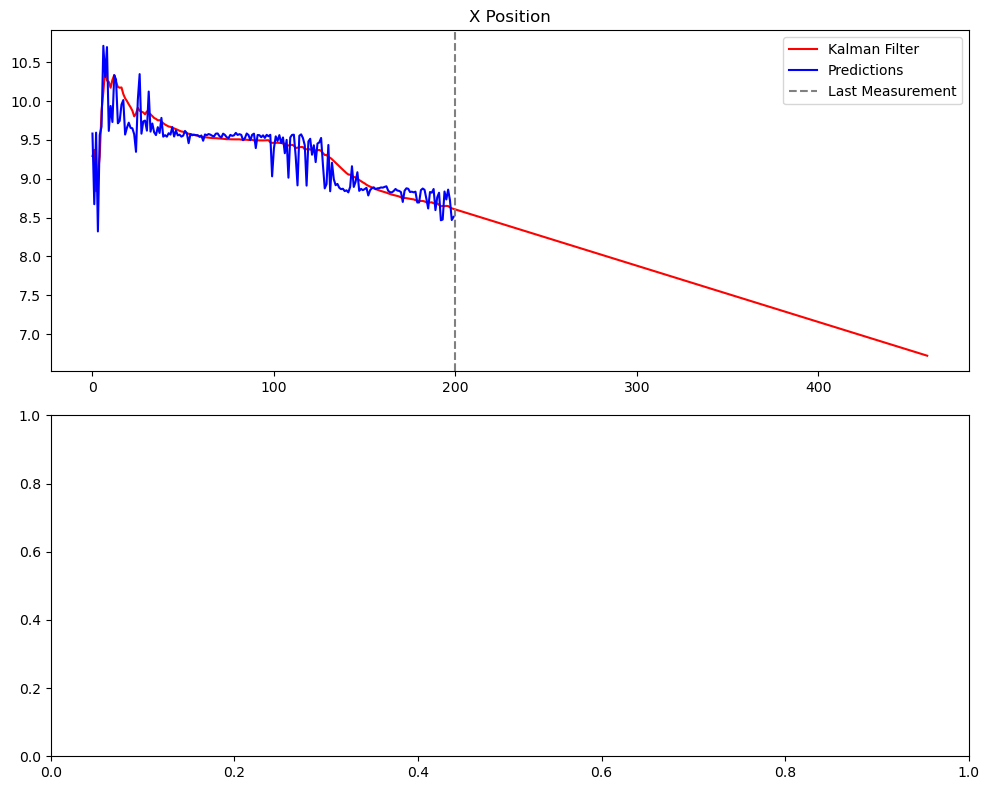

In [ ]:
# Plot separate coordinate positions
fig, axs = plt.subplots(2, 1, figsize=(10, 8))
# for i, label in enumerate(['X', 'Y', 'Z']):

# print(i)
axs[0].plot(positions[:, 0], label='Kalman Filter', color='red')
axs[0].plot(pred_pos[:last_measurement_ts, 0], label='Predictions', color='blue')
# axs[i].plot(truth_positions[:, i], label='Ground Truth', color='green')
# axs[i].plot(gt_labels[:, i], label='Ground Truth Labels', color='orange')
axs[i].axvline(x=last_measurement_ts, color='grey', linestyle='--', label='Last Measurement')
axs[0].set_title(f'X Position')
axs[0].legend()
# axs[1].legend()
plt.tight_layout()
plt.show()

In [ ]:
print(f"Last predicted position: {positions[-1]}")
print(f"Last ground truth position: {truth_positions[-1]}")
for i, label in enumerate(['X', 'Y', 'Z']):
    print(f"Accuracy in {label} position: {np.abs(positions[-1][i] - truth_positions[-1][i]):.4f} m")

Last predicted position: [ 7.41863791 -0.02298883  0.09877964]
Last ground truth position: [ 7.85375794 -0.00842198  0.11      ]
Accuracy in X position: 0.4351 m
Accuracy in Y position: 0.0146 m
Accuracy in Z position: 0.0112 m


In [ ]:
kf_preds.x

array([[ 7.31037937],
       [-0.01907743],
       [-0.24494484],
       [ 0.9893484 ],
       [-2.77618459],
       [-0.29034266],
       [ 0.        ],
       [ 0.        ],
       [-0.11269031]])

Experiment Taylor expansion vs KF to check for bug

In [ ]:
testset_in.__len__()

6

In [ ]:
# Load dataset
model = network.load_model('models/BEST-VideoClassification-all_lt_aug_q8_10ts_30e.pt', network.SCNNVideoClassification, trainset_in, device)
dataloader = trainloader_in
dataset = dataloader.dataset
KFClass = RollKF
cutoff_time = 1 # seconds
delta_t = 0.01 # seconds
process_var_acc = 0.01
meas_var_pos = 0.5



Loading model with weighted average: False
Flattened feature size: 14080
Number of x_cam bins: 161
Number of y_cam bins: 91
Number of R_cam bins: 101


In [ ]:
all_preds = network.get_preds_all_videos(model, dataloader, device=device, num_steps=10)

Predicting:  46%|████▋     | 13/28 [06:22<07:21, 29.44s/it]


RuntimeError: [enforce fail at alloc_cpu.cpp:114] data. DefaultCPUAllocator: not enough memory: you tried to allocate 3457843200 bytes.

In [ ]:

# Load video
def get_diffs(dataloader, model, device, cutoff, KFClass, all_preds=None):
    dataset = dataloader.dataset
    N = len(dataset)
    diffs = np.zeros((N, 3), dtype=np.float32)  # Store differences in X, Y, Z positions
    if all_preds is None: all_preds = network.get_preds_all_videos(model, dataloader, device=device, num_steps=10)
    for idx in tqdm(range(N), desc="Computing diffs"):
        positions, truth_positions = kf_positions_for_idx(idx, dataset, all_preds, validationset_world, cutoff, delta_t=0.01, process_var_acc=0.01, meas_var_pos=0.5)
        position_in_goal = positions[-1]
        truth_in_goal = truth_positions[-1]
        diffs[idx, :] = [abs(position_in_goal[i] - truth_in_goal[i]) for i in range(3)]
        # 7) Delete everything large before next iteration
        del positions, truth_positions
        del position_in_goal, truth_in_goal
        torch.cuda.empty_cache()
    return diffs

diffs = get_diffs(valid_loader_in, model, device, cutoff_time, KFClass, all_preds=all_preds)

Computing diffs:  71%|███████▏  | 15/21 [00:00<00:00, 46.20it/s]

Warning, many iterations. Maybe the ball is not going to the goal. TR: 95


Computing diffs: 100%|██████████| 21/21 [00:00<00:00, 50.26it/s]


In [ ]:
video_events, labels, _ = dataloader.dataset.__getitem__(7)

In [ ]:
print(all_preds[0])

[[37 37 37 38 38 39 39 39 40 40 37 36 36 37 37 40 40 40 39 41 41 42 40 40
  42 42 34]
 [32 33 35 38 38 42 43 44 48 50 52 53 56 60 60 64 66 65 69 74 76 76 80 80
  81 81 81]
 [ 4  4  4  4  4  4  5  5  5  5  4  3  3  3  3  3  4  4  4  3  3  3  3  3
   3  3  3]]


In [ ]:
diffs[:,0].mean()

np.float32(0.4621636)

# Combining both

In [ ]:
delta_t = 0.1
process_var_vel_xy = 0.1
process_var_vel_z  = 0.1  # (used in FlightKF; irrelevant in RollKF)
meas_var_pos = 0.5  # measurement noise variance on x,y,z

# Roll model: vz=0, az=0
kf_roll = RollKF(
    dt=delta_t,
    process_var_vel_xy=process_var_vel_xy,
    meas_var_pos=meas_var_pos,
    initial_cov=1e3
)

# Flight model: az = -9.8
kf_throw = ThrowKF(
    dt=delta_t,
    process_var_vel=process_var_vel_z,
    meas_var_pos=meas_var_pos,
    initial_cov=1e3
)

In [ ]:
Pij = [
    [0.95, 0.05],   # from “roll” → (stay roll = 0.95, switch to flight = 0.05)
    [0.05, 0.95]    # from “flight” → (switch to roll = 0.05, stay flight = 0.95)
]
mu_init = [0.5, 0.5]  # start 50/50 if you’re unsure

In [ ]:
from kalman import IMM_KF
imm = IMM_KF([kf_roll, kf_throw], Pij, mu_init)

In [ ]:
def get_diffs(dataloader, model, device, cutoff, KFClass, controls = None, all_preds=None, pred_type = 'goal'):
    dataset = dataloader.dataset
    N = len(dataset)
    diffs = np.zeros((N, 3), dtype=np.float32)  # Store differences in X, Y, Z positions
    if all_preds is None: all_preds = network.get_preds_all_videos(model, dataloader, device=device, num_steps=10)
    for idx in tqdm(range(N), desc="Computing diffs"):
        video, labels, length = dataset.__getitem__(idx)
        tr = dataset.__gettr__(idx)
        # Get predictions
        preds = all_preds[idx]
        labels = labels.transpose(0, 1)

        # Get ground truth
        _, gt_labels, _ = validationset_world.__getitemtr__(tr)
        gt_labels = gt_labels.cpu().numpy()
        pred_pos, _ = project_to_world(preds, dataset)

        kf_preds = KFClass([kf_roll, kf_throw], Pij, mu_init)
        kf_truth = KFClass([kf_roll, kf_throw], Pij, mu_init)
        last_measurement_ts = int(cutoff/delta_t)

        kf_preds, positions = kalman_loop_in_fov(kf_preds, pred_pos, gt_labels, last_measurement_ts, controls=controls)
        kf_truth, truth_positions = kalman_loop_in_fov(kf_truth, gt_labels, gt_labels, controls=controls)

        if pred_type == 'goal':
            kf_preds, positions = predict_until_goal(kf_preds, positions, controls=controls)
            kf_truth, truth_positions = predict_until_goal(kf_truth, truth_positions, controls=controls)
        elif pred_type == 'time':
            timesteps = 

        positions = np.array(positions)
        truth_positions = np.array(truth_positions)

        position_in_goal = positions[-1]
        truth_in_goal = truth_positions[-1]
        # print(f"Position in goal: {position_in_goal}, Truth in goal: {truth_in_goal}")
        diffs[idx, :] = [abs(position_in_goal[i][0] - truth_in_goal[i][0]) for i in range(3)]
        # 7) Delete everything large before next iteration
        del preds, positions, truth_positions
        del position_in_goal, truth_in_goal
        del kf_preds, kf_truth
        torch.cuda.empty_cache()
    return diffs

diffs = get_diffs(testloader_in, model, device, cutoff_time, IMM_KF, controls=[0.0, -9.81])

Computing diffs:   0%|          | 0/22 [00:05<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
diffs

array([[ 0.6384934 ,  2.6134965 ,  1.4517409 ],
       [ 1.2580618 ,  5.1495686 ,  2.7715538 ],
       [ 0.06124339,  2.2998023 ,  0.77510965],
       [ 2.0811093 ,  8.518434  ,  2.8206747 ],
       [ 0.09742268,  3.5647454 ,  0.50637484],
       [ 0.05607441,  0.7005674 ,  0.31830317],
       [ 1.6845164 ,  5.2682815 ,  3.7466364 ],
       [ 0.45242614,  5.6947484 ,  2.165989  ],
       [ 1.7412865 ,  5.783727  ,  0.82491165],
       [ 0.06106459,  2.293111  ,  1.1662619 ],
       [ 0.31005663,  2.3154    ,  1.2328112 ],
       [ 0.78488696,  2.6030102 ,  1.3346926 ],
       [ 0.05853748,  0.73087823,  0.1610239 ],
       [ 0.4893257 ,  1.0062231 ,  0.20288959],
       [ 0.9065198 ,  2.5137553 ,  1.2775865 ],
       [ 0.06190078,  2.3245008 ,  0.5670262 ],
       [ 1.7904751 ,  3.8278348 , 13.54435   ],
       [ 0.34791887,  5.0238028 ,  1.3100784 ],
       [ 0.38318607,  2.861513  ,  1.1932358 ],
       [ 0.09398787,  0.38471276,  0.1086758 ],
       [ 0.2956027 ,  2.207469  ,  0.797

In [ ]:
import numpy as np

# --- Sub‐filter for rolling: vz = 0, az = 0, z from measurements ---
class RollKF:
    def __init__(self, dt, process_var_vel_xy, meas_var_pos, initial_cov=1e3):
        self.dt = dt
        self.dim_x = 6  # [x, y, z, vx, vy, vz]
        self.dim_z = 3  # [x, y, z]
        # State vector
        self.x = np.zeros((6,1))
        # Covariance
        self.P = np.eye(self.dim_x) * initial_cov
        # F: freeze z and vz
        F = np.zeros((6,6))
        F[0,0]=1; F[0,3]=dt       # x ← x + vx·dt
        F[1,1]=1; F[1,4]=dt       # y ← y + vy·dt
        F[2,2]=1                 # z ← z
        F[3,3]=1                 # vx ← vx
        F[4,4]=1                 # vy ← vy
        # vz row left zero → vz_{k+1}=0
        self.F = F
        # Q: noise on vx, vy
        Q = np.zeros((6,6))
        Q[3,3] = process_var_vel_xy
        Q[4,4] = process_var_vel_xy
        self.Q = Q
        # H, R
        H = np.zeros((3,6)); H[0,0]=H[1,1]=H[2,2]=1
        self.H, self.R = H, np.eye(3)*meas_var_pos

    def predict(self):
        self.x = self.F @ self.x
        self.P = self.F @ self.P @ self.F.T + self.Q
        # pin vz = 0
        self.x[5,0] = 0.0
        self.P[5,:] = 0
        self.P[:,5] = 0

    def update(self, z):
        z = z.reshape((3,1))
        y = z - (self.H @ self.x)
        S = self.H @ self.P @ self.H.T + self.R
        K = self.P @ self.H.T @ np.linalg.inv(S)
        self.x = self.x + (K @ y)
        I = np.eye(self.dim_x)
        self.P = (I - K @ self.H) @ self.P
        # re‐pin vz = 0
        self.x[5,0] = 0.0
        self.P[5,:] = 0
        self.P[:,5] = 0

# --- Sub‐filter for flight: known a_z = -9.8 ---
class FlightKF:
    def __init__(self, dt, process_var_vel, meas_var_pos, initial_cov=1e3):
        self.dt = dt
        self.dim_x = 6
        self.dim_z = 3
        self.x = np.zeros((6,1))
        self.P = np.eye(self.dim_x) * initial_cov
        F = np.zeros((6,6))
        for i in range(3):
            F[i,i] = 1
            F[i,3+i] = dt
            F[3+i,3+i] = 1
        self.F = F
        self.B = np.array([[0],[0],[0.5*dt**2],[0],[0],[dt]])
        Q = np.zeros((6,6))
        Q[3,3]=Q[4,4]=Q[5,5]=process_var_vel
        self.Q = Q
        H = np.zeros((3,6)); H[0,0]=H[1,1]=H[2,2]=1
        self.H, self.R = H, np.eye(3)*meas_var_pos
        self.u_const = -9.8

    def predict(self, u=None):
        if u is None: u = self.u_const
        self.x = (self.F @ self.x) + (self.B * u)
        self.P = self.F @ self.P @ self.F.T + self.Q

    def update(self, z):
        z = z.reshape((3,1))
        y = z - (self.H @ self.x)
        S = self.H @ self.P @ self.H.T + self.R
        K = self.P @ self.H.T @ np.linalg.inv(S)
        self.x = self.x + (K @ y)
        I = np.eye(self.dim_x)
        self.P = (I - K @ self.H) @ self.P

# --- Regime‐switching loop via predicted z + hysteresis ---
delta_t = 0.1
process_var_vel_xy = 0.1
process_var_vel_z  = 0.1
meas_var_pos       = 0.5

roll_kf   = RollKF(delta_t, process_var_vel_xy, meas_var_pos)
throw_kf = FlightKF(delta_t, process_var_vel_z,    meas_var_pos)

# thresholds for switching (e.g. in meters or pixels)
z_floor   = 0.1
T_down    = z_floor + 0.1
T_up      = z_floor + 0.1

regime = 'roll'  # or 'flight', your initial guess

# Suppose `measurements` is an (N×3) array of [x, y, z]
idx = 5  # Index of the video to analyze
preds = all_preds[idx]  # Use the first video predictions for demonstration
video_events, labels, length = dataset.__getitem__(idx)
tr = dataset.__gettr__(idx)
# Get predictions
preds = all_preds[idx]
labels = labels.transpose(0, 1)

# Get ground truth
_, gt_labels, _ = validationset_world.__getitemtr__(tr)
gt_labels = gt_labels.cpu().numpy()

pred_pos, _ = project_to_world(preds, dataset)


for meas in pred_pos:
    # 1) predict with current regime
    print(meas.shape)
    if regime == 'flight':
        throw_kf.predict()       # uses u=-9.8 by default
        x_pred = throw_kf.x
    else:
        roll_kf.predict()
        x_pred = roll_kf.x

    z_pred  = x_pred[2,0]
    vz_pred = x_pred[5,0]

    # 2) hysteretic regime switch
    if regime == 'flight' and z_pred < T_down and vz_pred <= 0:
        regime = 'roll'
    elif regime == 'roll' and z_pred > T_up:
        regime = 'flight'

    # 3) update with measurement in that regime
    if regime == 'flight':
        throw_kf.update(meas)
        x_fused = throw_kf.x
    else:
        roll_kf.update(meas)
        x_fused = roll_kf.x

    # 4) x_fused now holds [x,y,z,vx,vy,vz]
    print(f"{regime.upper()} → pos = {x_fused[:3,0]}, vel = {x_fused[3:,0]}")


(3,)
ROLL → pos = [6.25145676 7.69391845 0.18324171], vel = [0.61895611 0.7617741  0.        ]
(3,)
ROLL → pos = [ 5.93019753 11.30436494  0.14663001], vel = [-3.02686012 34.39124806  0.        ]
(3,)
ROLL → pos = [ 5.81575741 12.05982689  0.15275232], vel = [-1.90867011 18.45015619  0.        ]
(3,)
ROLL → pos = [ 5.78622991 12.21420234  0.16956214], vel = [-1.21881723 11.22134452  0.        ]
(3,)
ROLL → pos = [ 5.77956337 12.22183845  0.1906476 ], vel = [-0.83375862  7.49659933  0.        ]
(3,)
ROLL → pos = [ 5.78039661 12.18673434  0.21387107], vel = [-0.60194387  5.33626423  0.        ]
(3,)
FLIGHT → pos = [ 5.85387381 11.46897208  0.43978011], vel = [0. 0. 0.]
(3,)
FLIGHT → pos = [ 5.8566677  11.4744459   0.54276257], vel = [0.02660912 0.05213288 0.46748643]
(3,)
FLIGHT → pos = [6.1537734  8.37431061 0.54830331], vel = [  1.77619701 -18.39981638  -0.46621299]
(3,)
FLIGHT → pos = [6.25241577 7.34410608 0.54590842], vel = [  1.43845169 -14.93681729  -1.04753173]
(3,)
FLIGHT → pos 

In [ ]:
all_preds[0].shape

(3, 462)

In [ ]:
import numpy as np
import pandas as pd

# (Assuming RollKF and FlightKF are already defined as in your code above)

# collect results
rows = []
for idx in range(len(dataset)):
    # 1) get preds, tr for this trajectory
    preds = all_preds[idx]                 # your predicted coords
    video_events, labels, length = dataset.__getitem__(idx)  
    labels = labels.transpose(0, 1)
    tr = dataset.__gettr__(idx)            # your trajectory ID getter
    # print(f"Trajectory: {tr}")

    # 2) project to world to get pred_pos [[x,y,z],...]
    pred_pos, _ = project_to_world(preds, dataset)

    # 3) compute predicted regime
    pred_regime = majority_regime(pred_pos)

    # 4) get ground truth flag
    #    Assumes `dataset.trajectories` is a DataFrame with columns "tr" and "is_roll"
    row = dataset.trajectories[dataset.trajectories["tr"] == tr]
    true_roll = bool(row["is_roll"].iloc[0])

    new_row = {
        "idx": idx,
        "tr": tr,
        "pred_is_roll": (pred_regime == "roll"),
        "true_is_roll": true_roll
    }
    rows.append(new_row)
    print(new_row)
# 5) assemble into a DataFrame
results_df = pd.DataFrame(rows)

# 6) inspect
# compute confusion matrix
tp = np.sum((results_df.pred_is_roll == True) &  (results_df.true_is_roll == True))
fn = np.sum((results_df.pred_is_roll == False) & (results_df.true_is_roll == True))
fp = np.sum((results_df.pred_is_roll == True) &  (results_df.true_is_roll == False))
tn = np.sum((results_df.pred_is_roll == False) & (results_df.true_is_roll == False))

confusion_df = pd.DataFrame(
    [[tp, fn],
     [fp, tn]],
    index=["True Roll", "True Flight"],
    columns=["Pred Roll", "Pred Flight"]
)

print("\nConfusion matrix (rows=true, columns=predicted):")
print(confusion_df)

acc = (tp + tn) / (tp + tn + fp + fn)
print(f"\nOverall accuracy: {acc:.3f}")


NameError: name 'all_preds' is not defined

## View plots
266 and 304

In [ ]:
type(all_preds)

list

Using idx 7 for trajectory 255


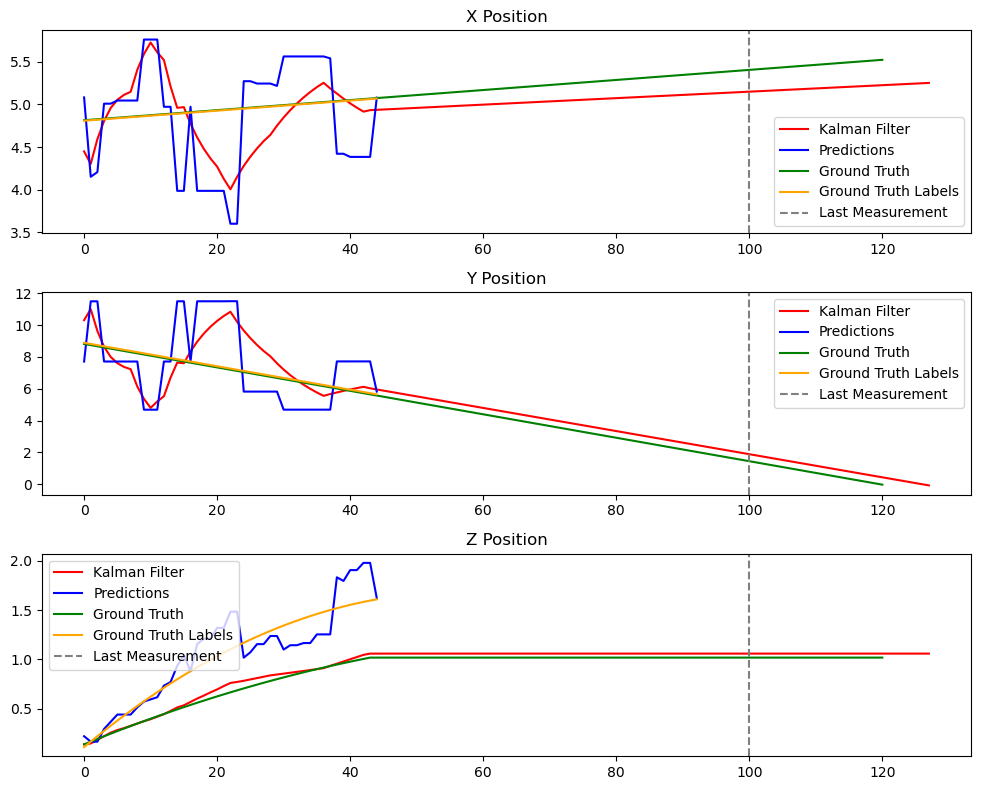

In [ ]:
tr = 255
_, _ = kf_positions_for_tr(tr, dataset, all_preds, world_dataset, RollKF, cutoff_time, print_graph=True)

In [ ]:
idx = 3
video_events, labels, length = dataset.__getitem__(idx)
preds = all_preds[idx]
gen = dt.image_gen_for_video(video_events, labels, preds)

In [ ]:
dt.show_next_img_w_pred(gen)

StopIteration: 

In [ ]:
dataset.trajectories

,tr,r0_x,r0_y,r0_z,v0_x,v0_y,v0_z,g_x,g_y,g_x_bin,g_y_bin,tf,is_roll,tg,type,goes_in
7,10,9.191919,10.555556,0.11,-0.474653,-1.942860,0.000000,6.613128,0.110000,3,1,20.387360,True,6.454829,in,1
67,125,10.040404,9.666667,0.11,-0.474653,-1.942860,0.000000,7.678774,0.110000,5,1,20.387360,True,5.800705,in,1
26,53,6.646465,5.666667,0.11,-0.082615,-3.102348,0.000000,6.495562,0.110000,2,1,31.635558,True,1.882588,in,1
75,266,10.888889,11.000000,0.11,-0.671062,-2.746802,0.000000,8.201517,0.110000,7,1,28.823509,True,4.329875,almost_in,0
135,332,8.202020,4.555556,0.11,0.478129,-5.973524,4.065215,8.566653,0.357504,7,1,0.828790,False,0.762624,almost_in,0
80,272,6.080808,9.444444,0.11,0.617569,-7.715628,5.886132,6.836753,-0.034337,3,0,1.200027,False,1.224067,almost_in,0
107,304,5.656566,6.555556,0.11,1.506453,-4.996022,6.861972,7.633266,0.668782,5,2,1.398975,False,1.312155,in,1
70,255,4.808081,8.888889,0.11,0.582529,-7.277862,5.552167,5.519559,-0.425692,0,0,1.131940,False,1.221360,almost_in,0
106,303,4.808081,8.222222,0.11,2.297955,-7.620971,6.053115,7.287332,0.931188,4,2,1.234070,False,1.078894,in,1
47,95,7.353535,3.222222,0.11,-0.053241,-1.999291,0.000000,7.267728,0.110000,4,1,20.387360,True,1.680983,in,1


The detection of flying vs rolling is working

New pipeline:
- Both filters at the same time
- Majority regime decides which one will be used
- Cutoff
- Predict until goal



This is for majority regime accuracy:

In [ ]:
# thresholds for switching




Evaluating with cutoff time: 0.01 seconds

Confusion matrix (rows=true, columns=predicted):
             Pred Roll  Pred Flight
True Roll           48            0
True Flight         34            5

Overall accuracy: 0.609

Evaluating with cutoff time: 0.02 seconds

Confusion matrix (rows=true, columns=predicted):
             Pred Roll  Pred Flight
True Roll           48            0
True Flight         31            8

Overall accuracy: 0.644

Evaluating with cutoff time: 0.05 seconds

Confusion matrix (rows=true, columns=predicted):
             Pred Roll  Pred Flight
True Roll           48            0
True Flight         22           17

Overall accuracy: 0.747

Evaluating with cutoff time: 0.1 seconds

Confusion matrix (rows=true, columns=predicted):
             Pred Roll  Pred Flight
True Roll           48            0
True Flight          6           33

Overall accuracy: 0.931

Evaluating with cutoff time: 0.2 seconds

Confusion matrix (rows=true, columns=predicted):
     

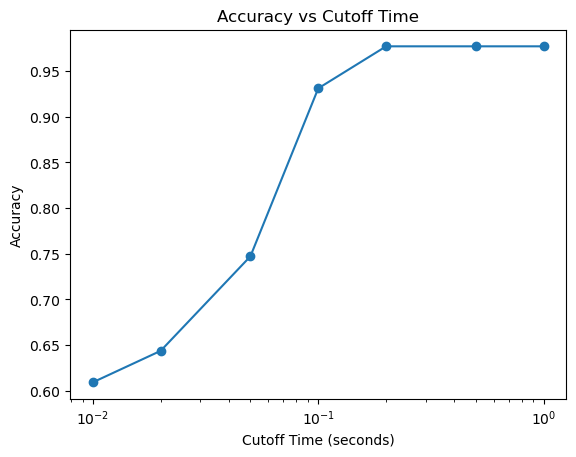

In [ ]:

# collect results
cutoff_times = [0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1]  # seconds
accuracies = []
for cutoff_time in cutoff_times:
    print(f"\nEvaluating with cutoff time: {cutoff_time} seconds")
    rows = []
    for idx in range(len(dataset)):
        # 1) get preds, tr for this trajectory
        preds = all_preds[idx]                 # your predicted coords
        video_events, labels, length = dataset.__getitem__(idx)  
        labels = labels.transpose(0, 1)
        tr = dataset.__gettr__(idx)            # your trajectory ID getter
        # print(f"Trajectory: {tr}")

        # 2) project to world to get pred_pos [[x,y,z],...]
        pred_pos, _ = project_to_world(preds, dataset)

        last_measurement_ts = int(cutoff_time / delta_t)

        # 3) compute predicted regime
        kf_pred, kf_pred_positions, pred_regime = majority_regime(pred_pos, last_measurement_ts=last_measurement_ts)

        # 4) get ground truth flag
        #    Assumes `dataset.trajectories` is a DataFrame with columns "tr" and "is_roll"
        row = dataset.trajectories[dataset.trajectories["tr"] == tr]
        true_roll = bool(row["is_roll"].iloc[0])

        new_row = {
            "idx": idx,
            "tr": tr,
            "pred_is_roll": (pred_regime == "roll"),
            "true_is_roll": true_roll
        }
        rows.append(new_row)
        # print(new_row)
    # 5) assemble into a DataFrame
    results_df = pd.DataFrame(rows)

    # 6) inspect
    # compute confusion matrix
    tp = np.sum((results_df.pred_is_roll == True) &  (results_df.true_is_roll == True))
    fn = np.sum((results_df.pred_is_roll == False) & (results_df.true_is_roll == True))
    fp = np.sum((results_df.pred_is_roll == True) &  (results_df.true_is_roll == False))
    tn = np.sum((results_df.pred_is_roll == False) & (results_df.true_is_roll == False))

    confusion_df = pd.DataFrame(
        [[tp, fn],
        [fp, tn]],
        index=["True Roll", "True Flight"],
        columns=["Pred Roll", "Pred Flight"]
    )

    print("\nConfusion matrix (rows=true, columns=predicted):")
    print(confusion_df)

    acc = (tp + tn) / (tp + tn + fp + fn)
    print(f"\nOverall accuracy: {acc:.3f}")
    accuracies.append(acc)
plt.plot(cutoff_times, accuracies, marker='o')
plt.xlabel('Cutoff Time (seconds)')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Cutoff Time')
plt.xscale('log')

Now lets compute the whole thing for one iteration and plot it

Trajectory: 35
Predicted regime: roll
True regime: roll
Traj type: in


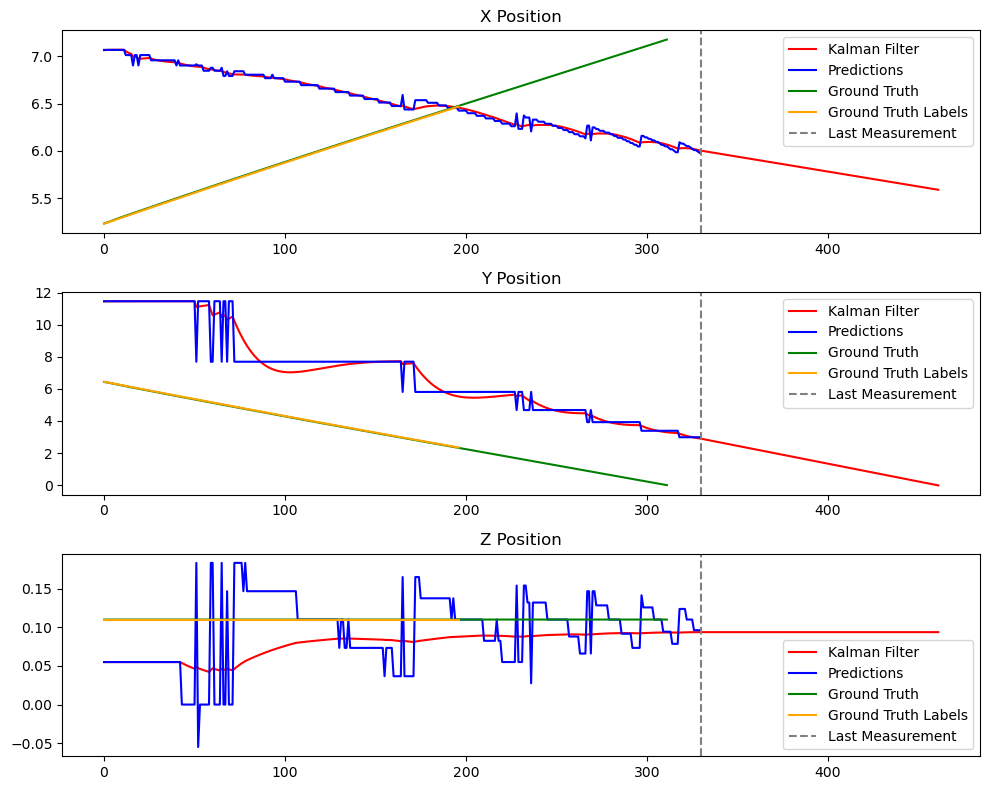

In [ ]:
delta_t = 0.01
process_var_vel_xy = 0.1
process_var_vel_z  = 0.1
meas_var_pos       = 0.5
rows = []
# for idx in range(len(dataset)):
    # 1) get preds, tr for this trajectory

idx = 0
preds = all_preds[idx]                 # your predicted coords
video_events, labels, length = dataset.__getitem__(idx)  
labels = labels.transpose(0, 1)
tr = dataset.__gettr__(idx)            # your trajectory ID getter
print(f"Trajectory: {tr}")

# Get ground truth
_, gt_labels, _ = trainset_world.__getitemtr__(tr)
gt_labels = gt_labels.cpu().numpy()

# 2) project to world to get pred_pos [[x,y,z],...]
pred_pos, _ = project_to_world(preds, dataset)

# 3) compute predicted regime
kf_pred, kf_pred_positions, pred_regime = majority_regime(pred_pos)
print(f"Predicted regime: {pred_regime}")
row = dataset.trajectories[dataset.trajectories["tr"] == tr]
true_roll = bool(row["is_roll"].iloc[0])
gt_regime = 'roll' if true_roll else 'throw'
print(f'True regime: {gt_regime}')
print(f"Traj type: {row['type'].iloc[0]}")

KFClass = RollKF if pred_regime == 'roll' else ThrowKF
kf_truth = KFClass(delta_t, process_var_vel_xy, meas_var_pos)

kf_truth, truth_positions = kalman_loop_in_fov(kf_truth, gt_labels, gt_labels)

kf_pred, kf_pred_positions = predict_until_goal(kf_pred, kf_pred_positions)
kf_truth, truth_positions = predict_until_goal(kf_truth, truth_positions, truth=True)

kf_pred_positions = np.array(kf_pred_positions)
truth_positions = np.array(truth_positions)

print_kf_graph(kf_pred_positions, truth_positions, pred_pos, gt_labels)

I need to get the predictions again, the ground truth and the predictions are missaligned

Now Ill code the new get_differences function

I want also to extract whether the ball was going in or out or almost in

In [ ]:
dataloader = trainloader_in
dataset = dataloader.dataset

<>:30: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:30: SyntaxWarning: "is" with a literal. Did you mean "=="?
C:\Users\realenriquem\AppData\Local\Temp\ipykernel_28076\920212380.py:30: SyntaxWarning: "is" with a literal. Did you mean "=="?
  elif check_result is 'goal':


In [ ]:
len(all_preds)

NameError: name 'all_preds' is not defined

In [ ]:
all_preds = network.get_preds_all_videos(model, dataloader, device=device, num_steps=10)


Predicting:  43%|████▎     | 12/28 [03:38<04:51, 18.24s/it]


RuntimeError: [enforce fail at alloc_cpu.cpp:114] data. DefaultCPUAllocator: not enough memory: you tried to allocate 3398860800 bytes.

In [ ]:
torch.save(all_preds, "all_preds.pth")

In [ ]:
y_positions = all_preds[0][1]  # Assuming the second column is Y positions
cutoff_distance = 28
np.where(np.abs(y_positions) < cutoff_distance)[0][0]

np.int64(220)

In [ ]:
all_preds[0][1]

array([36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36,
       36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36,
       36, 36, 36, 36, 36, 36, 36, 36, 36, 35, 35, 35, 35, 35, 35, 35, 35,
       35, 34, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35, 35,
       34, 35, 35, 35, 35, 35, 35, 35, 35, 34, 35, 34, 34, 34, 34, 34, 34,
       34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34, 34,
       34, 34, 34, 34, 34, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33,
       33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 32, 33, 33, 32, 32, 33,
       32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32,
       32, 32, 31, 32, 32, 32, 32, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31,
       31, 31, 31, 31, 31, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30, 30,
       30, 30, 30, 30, 30, 29, 30, 29, 29, 29, 29, 29, 29, 29, 29, 29, 29,
       29, 29, 29, 29, 29, 29, 28, 28, 28, 28, 28, 28, 28, 29, 28, 28, 27,
       27, 27, 27, 27, 27

In [ ]:
len(all_preds)

23

Using cutoff distance: 9 meters.


Evaluating Kalman Filter:   1%|          | 1/109 [00:00<00:17,  6.30it/s]

197 330 197
Warning, many iterations. Maybe the ball is not going to the goal.  Ground truth
325 248 392


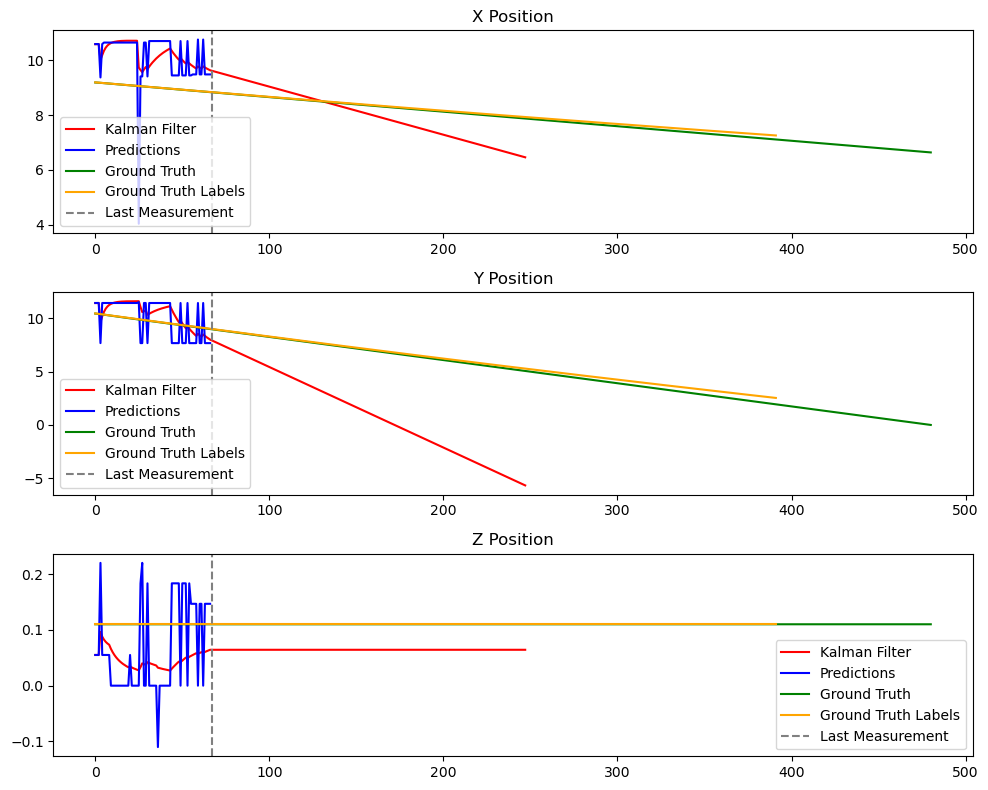

TypeError: cannot unpack non-iterable NoneType object

In [ ]:
cutoff_distance = 9 # seconds
diffs, conf_mt = evaluate_kf(dataloader, model, device, cutoff_distance = cutoff_distance, all_preds=all_preds)

In [ ]:
gt_labels[:,1]

array([6.4444447, 6.422602 , 6.4007697, 6.3789463, 6.3571324, 6.335328 ,
       6.313533 , 6.2917476, 6.2699714, 6.2482047, 6.2264476, 6.2046995,
       6.1829615, 6.1612325, 6.139513 , 6.117803 , 6.0961027, 6.0744114,
       6.0527296, 6.0310574, 6.0093946, 5.9877415, 5.9660974, 5.9444633,
       5.922838 , 5.901222 , 5.8796163, 5.85802  , 5.8364325, 5.8148546,
       5.7932863, 5.771727 , 5.750178 , 5.7286377, 5.707107 , 5.685586 ,
       5.6640744, 5.642572 , 5.621079 , 5.5995955, 5.5781217, 5.5566573,
       5.535202 , 5.5137568, 5.4923205, 5.4708934, 5.4494762, 5.4280686,
       5.40667  , 5.385281 , 5.3639016, 5.342531 , 5.321171 , 5.2998195,
       5.2784777, 5.2571454, 5.2358227, 5.214509 , 5.1932054, 5.171911 ,
       5.150625 , 5.1293497, 5.1080837, 5.086827 , 5.0655794, 5.0443416,
       5.0231133, 5.001894 , 4.9806843, 4.959484 , 4.9382935, 4.9171124,
       4.8959403, 4.8747783, 4.8536253, 4.832482 , 4.8113475, 4.790223 ,
       4.769108 , 4.748002 , 4.726906 , 4.705819 , 

In [ ]:
# Np mean diffs[0]
mean_diffs = diffs.mean(axis=0)
print(f"Mean differences in positions: {mean_diffs}")

# Plot distribution
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.hist(diffs[:, 0], bins=30, alpha=0.5, label='X Position', color='blue')
plt.hist(diffs[:, 1], bins=30, alpha=0.5, label='Y Position', color='orange')
plt.hist(diffs[:, 2], bins=30, alpha=0.5, label='Z Position', color='green')
plt.title('Distribution of Position Differences')

NameError: name 'diffs' is not defined

# Next steps

Loop for diff cutoffs

Train better versions of the model


I need to remember to do something for the ball going outside the field of view



Check difference after 0.5 s, not only when the goal is hit

# Now we really evaluate

First Rolling vs Throwing

In [40]:
model = network.load_model('models/BEST-VideoClassification_q8_5ts_38e.pt', network.SCNNVideoClassification, dataset_in, device)

Loading model with weighted average: False
Flattened feature size: 14080
Number of x_cam bins: 161
Number of y_cam bins: 91
Number of R_cam bins: 101


c:\Users\realenriquem\OneDrive - Sioux Group B.V\Documents\Git\BallTrackingSNN\network.py:2304: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  preds = []


In [ ]:
model = network.load_model('models/BEST-VideoClassification-all_lt_aug_q8_10ts_30e.pt', network.SCNNVideoClassification, dataset_in, device)

NameError: name 'network' is not defined

In [49]:
dataloader = dataloader_in
dataset = dataloader.dataset
dataloader_world = dataloader_world


In [6]:
all_preds = network.get_preds_all_videos(model, dataloader, device=device, num_steps=4)
torch.save(all_preds, "all_preds_4ts.pth")

Predicting: 100%|██████████| 22/22 [07:13<00:00, 19.71s/it]


In [ ]:
network.measure_inference_time_per_image_for_videos(model, dataloader, device=device, num_steps=4, num_batches=20)

Average inference time per image over 20 batches: 0.004206 s


0.004206078111823815

In [ ]:
network.measure_inference_time_per_image_for_videos(model, dataloader, device=device, num_steps=5, num_batches=20)

Average inference time per image over 20 batches: 0.005205 s


0.00520499958483484

In [ ]:
all_preds = torch.load("all_preds_4ts.pth")
all_preds = [
    p.detach().cpu().numpy()
    if isinstance(p, torch.Tensor) else p
    for p in all_preds
]

C:\Users\realenriquem\AppData\Local\Temp\ipykernel_34464\3020968641.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  all_preds = torch.load("all_preds_4ts.pth")


Evaluating video classification tracker
Error x_cam: μ=-1.05, σ=15.49, 95% CI=[-31.41, 29.31] pixels
Durbin–Watson x_cam: 0.95
Error y_cam: μ=-0.08, σ=4.65, 95% CI=[-9.19, 9.04] pixels
Durbin–Watson y_cam: 0.68
Error R_cam: μ=0.03, σ=2.14, 95% CI=[-4.16, 4.23] pixels
Durbin–Watson R_cam: 0.63


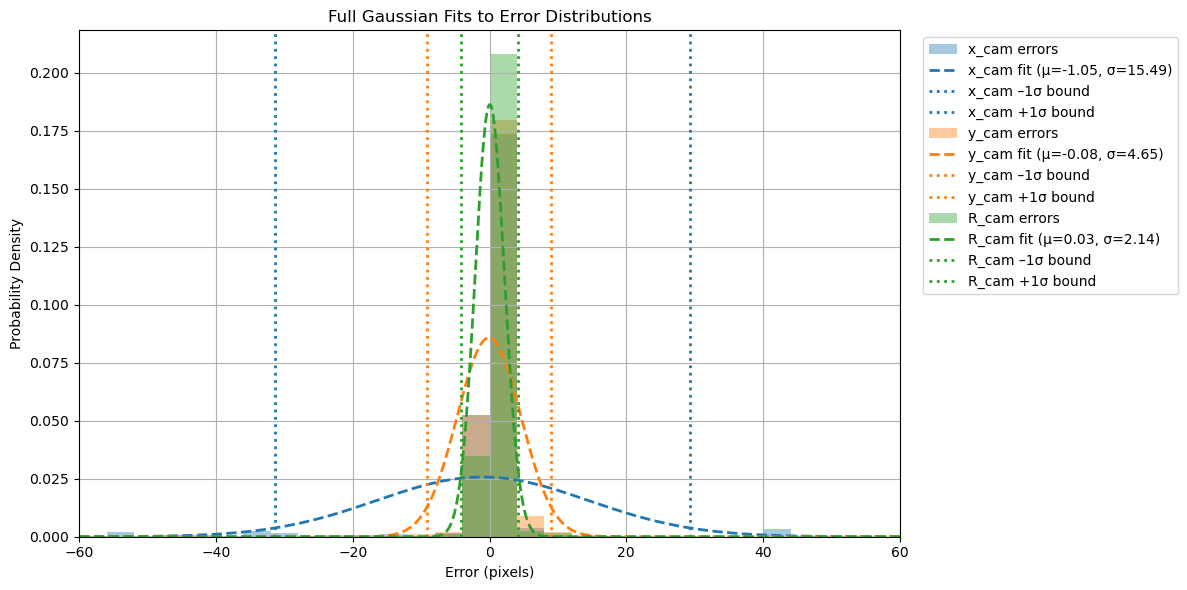

In [50]:
error = model.evaluate(dataloader, device, num_steps=4, print_results=True, weighted_avg=False, operation='distribution')
# print(f"Error: {np.linalg.norm(error):.4f}")


In [ ]:
from statsmodels.stats.stattools import durbin_watson
print(durbin_watson(errors_x))

In [ ]:
error = model.evaluate(dataloader, device, num_steps=model.training_params["num_steps"], print_results=True, weighted_avg=True)
print(f"WAvg Error: {np.linalg.norm(error):.4f}")

Evaluating video classification tracker
Error at 1 timesteps: 3.6106834608591662
Evaluating video classification tracker
Error at 2 timesteps: 2.126546082600582
Evaluating video classification tracker
Error at 3 timesteps: 1.8034848897105884
Evaluating video classification tracker
Error at 4 timesteps: 1.692086162601835
Evaluating video classification tracker
Error at 5 timesteps: 1.7296178135028197
Evaluating video classification tracker
Error at 6 timesteps: 1.7683095736648953
Evaluating video classification tracker
Error at 7 timesteps: 1.8367415926477761
Evaluating video classification tracker
Error at 8 timesteps: 1.9626061292251533
Evaluating video classification tracker
Error at 9 timesteps: 2.161243227988613


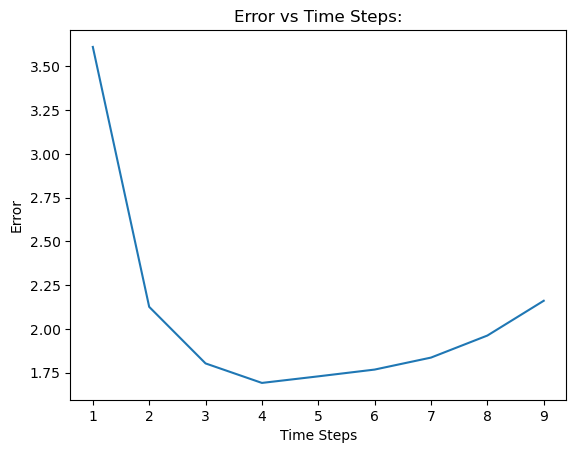

In [ ]:
network.plot_timestep_curve(model, dataloader, device, interval=[1, 10, 1])

(3, 11634)

## Evaluating to the goal

Evaluating Kalman Filter with cutoff distance: 1
Using cutoff distance: 1 meters.
Using goal prediction.


Evaluating Kalman Filter: 100%|██████████| 87/87 [00:01<00:00, 49.30it/s]
C:\Users\realenriquem\AppData\Local\Temp\ipykernel_40752\3986885533.py:21: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_distances = pd.concat([df_distances, pd.DataFrame([new_row])], ignore_index=True)



Confusion matrix:
          Pred_in  Pred_out
True_in        32         4
True_out        5        26

Overall accuracy: 0.866
--------------------------------------------------
Evaluating Kalman Filter with cutoff distance: 2
Using cutoff distance: 2 meters.
Using goal prediction.


Evaluating Kalman Filter: 100%|██████████| 87/87 [00:01<00:00, 49.73it/s]



Confusion matrix:
          Pred_in  Pred_out
True_in        32         2
True_out        5        26

Overall accuracy: 0.892
--------------------------------------------------
Evaluating Kalman Filter with cutoff distance: 3
Using cutoff distance: 3 meters.
Using goal prediction.


Evaluating Kalman Filter: 100%|██████████| 87/87 [00:01<00:00, 48.81it/s]



Confusion matrix:
          Pred_in  Pred_out
True_in        32         2
True_out        6        25

Overall accuracy: 0.877
--------------------------------------------------
Evaluating Kalman Filter with cutoff distance: 4
Using cutoff distance: 4 meters.
Using goal prediction.


Evaluating Kalman Filter: 100%|██████████| 87/87 [00:01<00:00, 52.03it/s]



Confusion matrix:
          Pred_in  Pred_out
True_in        30         2
True_out        8        23

Overall accuracy: 0.841
--------------------------------------------------
Evaluating Kalman Filter with cutoff distance: 5
Using cutoff distance: 5 meters.
Using goal prediction.


Evaluating Kalman Filter: 100%|██████████| 87/87 [00:01<00:00, 52.68it/s]



Confusion matrix:
          Pred_in  Pred_out
True_in        19         6
True_out        5        22

Overall accuracy: 0.788
--------------------------------------------------
Evaluating Kalman Filter with cutoff distance: 6
Using cutoff distance: 6 meters.
Using goal prediction.


Evaluating Kalman Filter: 100%|██████████| 87/87 [00:01<00:00, 56.82it/s]



Confusion matrix:
          Pred_in  Pred_out
True_in        27         4
True_out       15        13

Overall accuracy: 0.678
--------------------------------------------------
Evaluating Kalman Filter with cutoff distance: 7
Using cutoff distance: 7 meters.
Using goal prediction.


Evaluating Kalman Filter: 100%|██████████| 87/87 [00:01<00:00, 55.02it/s]



Confusion matrix:
          Pred_in  Pred_out
True_in         7         1
True_out        2         7

Overall accuracy: 0.824
--------------------------------------------------
Evaluating Kalman Filter with cutoff distance: 8
Using cutoff distance: 8 meters.
Using goal prediction.


Evaluating Kalman Filter: 100%|██████████| 87/87 [00:01<00:00, 66.62it/s]



Confusion matrix:
          Pred_in  Pred_out
True_in        12         4
True_out       14         9

Overall accuracy: 0.538
--------------------------------------------------
Evaluating Kalman Filter with cutoff distance: 9
Using cutoff distance: 9 meters.
Using goal prediction.


Evaluating Kalman Filter: 100%|██████████| 87/87 [00:01<00:00, 69.21it/s]



Confusion matrix:
          Pred_in  Pred_out
True_in         8         1
True_out        4         3

Overall accuracy: 0.688
--------------------------------------------------
  cutoff_distance  mean_diff_x  mean_diff_y  mean_diff_z num_trajectories  \
0               1     0.137631     0.021146     0.079947               32   
1               2     0.145376     0.021097     0.083635               32   
2               3     0.124901     0.021222     0.079671               32   
3               4     0.189449     0.026925     0.084493               30   
4               5     0.304267     0.036491     0.126989               19   
5               6     0.332390     0.037115     0.094251               27   
6               7     0.369030     0.098954     0.291294                7   
7               8     0.373798     0.056644     0.105288               12   
8               9     0.512619     0.063676     0.043811                8   

   mean_diff_t  accuracy  stop_accuracy  
0     0.

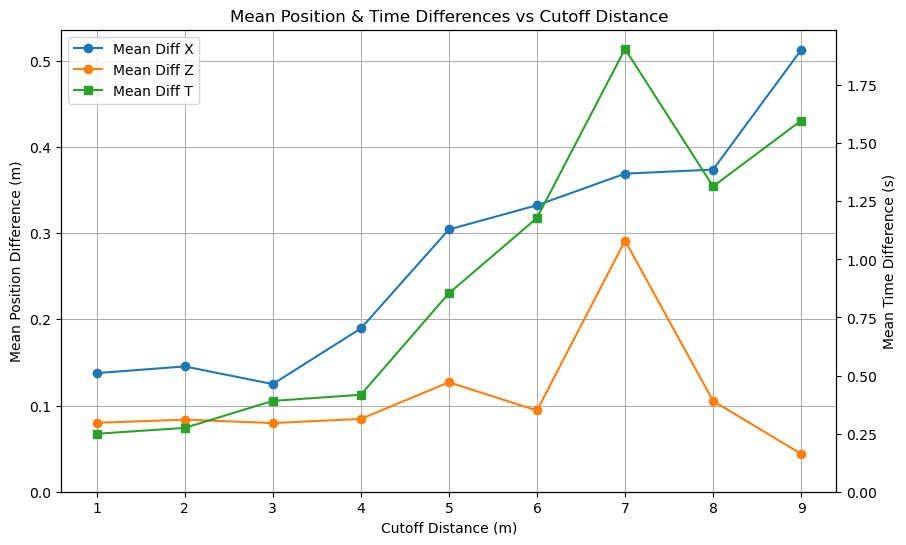

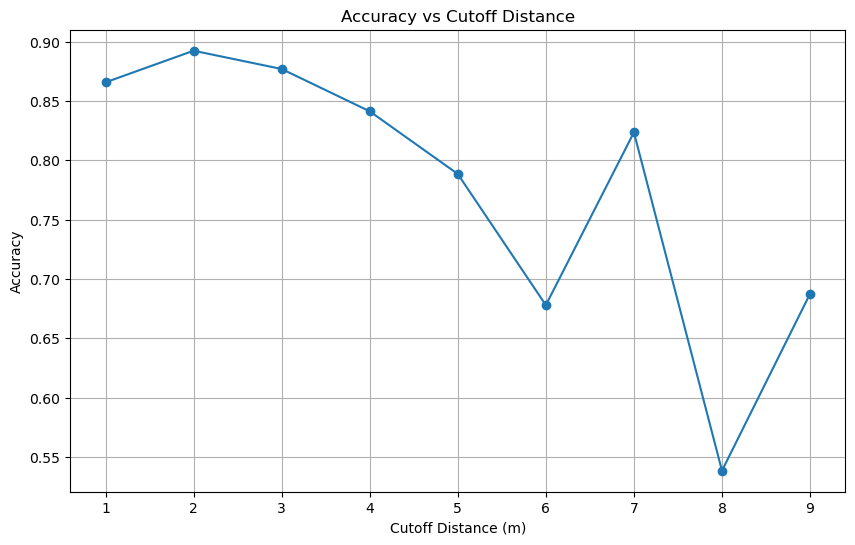

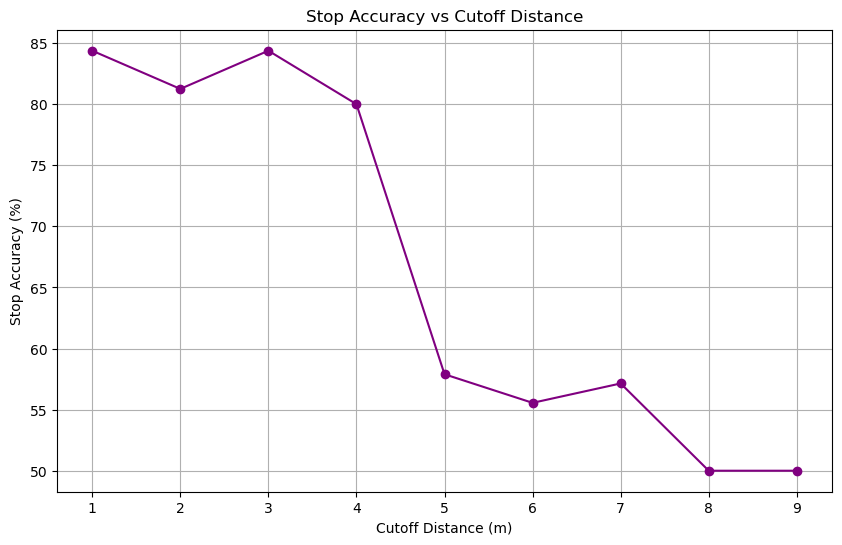

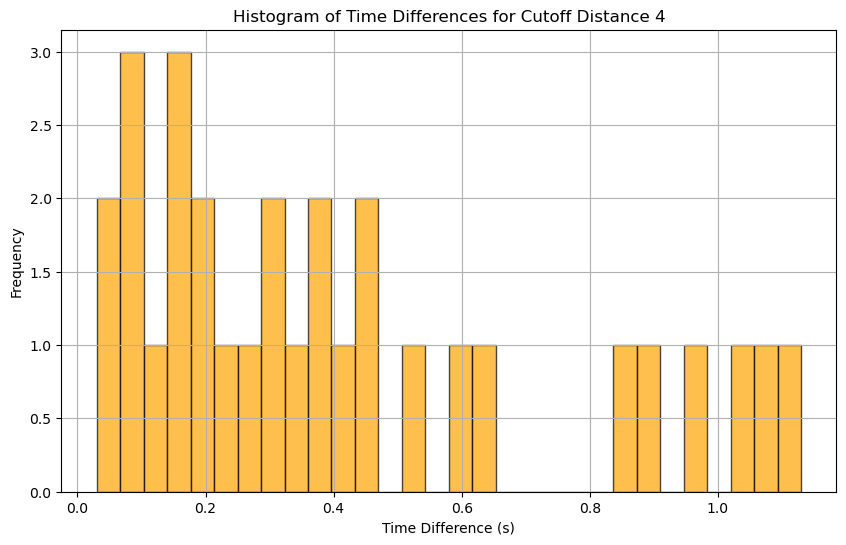

In [43]:
cutoff_distances = [1, 2, 3, 4, 5, 6, 7, 8, 9]
df_distances = pd.DataFrame(columns=['cutoff_distance', 'mean_diff_x', 'mean_diff_y', 'mean_diff_z', 'num_trajectories'])
conf_matrices = {}
for cutoff_distance in cutoff_distances:
    print(f"Evaluating Kalman Filter with cutoff distance: {cutoff_distance}")
    diffs, conf_mt, accuracy = evaluate_kf(dataloader, model, device, cutoff_distance = cutoff_distance, all_preds=all_preds)
    conf_matrices[cutoff_distance] = conf_mt
    # Percentage of trajectories for which diff_x is less than 0.2
    half_size_of_robot = 0.3
    stop_accuracy = (diffs[:, 0] < half_size_of_robot).mean() * 100
    new_row = {
        'cutoff_distance': cutoff_distance,
        'mean_diff_x': diffs[:, 0].mean(),
        'mean_diff_y': diffs[:, 1].mean(),
        'mean_diff_z': diffs[:, 2].mean(),
        'mean_diff_t': diffs[:, 3].mean(),
        'accuracy': accuracy,
        'num_trajectories': len(diffs),
        'stop_accuracy': stop_accuracy
    }
    df_distances = pd.concat([df_distances, pd.DataFrame([new_row])], ignore_index=True)
    print('-'*50)
    if cutoff_distance == 4:
        diffs4 = diffs
print(df_distances)

# # Plot mean diff x
# plt.figure(figsize=(10, 6))
# plt.plot(df_distances['cutoff_distance'], df_distances['mean_diff_x'], marker='o', label='Mean Diff X')
# # plt.plot(df_distances['cutoff_distance'], df_distances['mean_diff_y'], marker='o', label='Mean Diff Y')
# plt.plot(df_distances['cutoff_distance'], df_distances['mean_diff_z'], marker='o', label='Mean Diff Z')
# plt.title('Mean Position Differences vs Cutoff Distance')
# plt.xlabel('Cutoff Distance (m)')
# plt.ylabel('Mean Position Difference (m)')
# plt.legend()
# plt.grid()

# Plot mean diff_x and t
fig, ax1 = plt.subplots(figsize=(10, 6))
x = df_distances['cutoff_distance']
y1 = df_distances['mean_diff_x']
y3 = df_distances['mean_diff_z']
yt = df_distances['mean_diff_t']
# Left axis: spatial differences
ax1.plot(x, y1, marker='o', label='Mean Diff X')
# ax1.plot(x, df_distances['mean_diff_y'], marker='o', label='Mean Diff Y')
ax1.plot(x, y3, marker='o', label='Mean Diff Z')
ax1.set_xlabel('Cutoff Distance (m)')
ax1.set_ylabel('Mean Position Difference (m)')
ax1.grid(True)
ax1.set_ylim(bottom=0)  # Set y-axis to start from 0

# Twin axis for time difference
ax2 = ax1.twinx()
ax2.plot(x, yt, marker='s', color='tab:green', label='Mean Diff T')
ax2.set_ylabel('Mean Time Difference (s)')
ax2.set_ylim(bottom=0)  # Set y-axis to start from 0

# Combine legends
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left')

plt.title('Mean Position & Time Differences vs Cutoff Distance')
plt.show()

# Plot accuracy
plt.figure(figsize=(10, 6))
plt.plot(df_distances['cutoff_distance'], df_distances['accuracy'], marker='o', label='Accuracy')
plt.title('Accuracy vs Cutoff Distance')
plt.xlabel('Cutoff Distance (m)')
plt.ylabel('Accuracy')
plt.grid()

# Plot stop accuracy
plt.figure(figsize=(10, 6))
plt.plot(df_distances['cutoff_distance'], df_distances['stop_accuracy'], marker='o', label='Stop Accuracy', color = 'purple')
plt.title('Stop Accuracy vs Cutoff Distance')
plt.xlabel('Cutoff Distance (m)')
plt.ylabel('Stop Accuracy (%)')
plt.grid()

# Plot histogram of time diffs for cutoff distance 4
plt.figure(figsize=(10, 6))
plt.hist(diffs4[:, 3], bins=30, alpha=0.7, color='orange', edgecolor='black')
plt.title('Histogram of Time Differences for Cutoff Distance 4')
plt.xlabel('Time Difference (s)')
plt.ylabel('Frequency')
plt.grid()



Evaluating Kalman Filter with cutoff time: 0.5
Using cutoff time: 0.5 seconds.
Using goal prediction.


Evaluating Kalman Filter: 100%|██████████| 87/87 [00:01<00:00, 61.87it/s]
C:\Users\realenriquem\AppData\Local\Temp\ipykernel_40752\3654853690.py:20: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_time = pd.concat([df_time, pd.DataFrame([new_row])], ignore_index=True)



Confusion matrix:
          Pred_in  Pred_out
True_in         4         4
True_out        9        10

Overall accuracy: 0.519
--------------------------------------------------
Evaluating Kalman Filter with cutoff time: 1
Using cutoff time: 1 seconds.
Using goal prediction.


Evaluating Kalman Filter: 100%|██████████| 87/87 [00:01<00:00, 67.68it/s]



Confusion matrix:
          Pred_in  Pred_out
True_in        15         1
True_out        7         8

Overall accuracy: 0.742
--------------------------------------------------
Evaluating Kalman Filter with cutoff time: 1.5
Using cutoff time: 1.5 seconds.
Using goal prediction.


Evaluating Kalman Filter: 100%|██████████| 87/87 [00:01<00:00, 67.50it/s]



Confusion matrix:
          Pred_in  Pred_out
True_in        12         1
True_out        2         8

Overall accuracy: 0.870
--------------------------------------------------
Evaluating Kalman Filter with cutoff time: 2
Using cutoff time: 2 seconds.
Using goal prediction.


Evaluating Kalman Filter: 100%|██████████| 87/87 [00:01<00:00, 66.22it/s]



Confusion matrix:
          Pred_in  Pred_out
True_in        10         1
True_out        2         6

Overall accuracy: 0.842
--------------------------------------------------
Evaluating Kalman Filter with cutoff time: 2.5
Using cutoff time: 2.5 seconds.
Using goal prediction.


Evaluating Kalman Filter: 100%|██████████| 87/87 [00:01<00:00, 79.21it/s]



Confusion matrix:
          Pred_in  Pred_out
True_in         6         1
True_out        2         2

Overall accuracy: 0.727
--------------------------------------------------
Evaluating Kalman Filter with cutoff time: 3
Using cutoff time: 3 seconds.
Using goal prediction.


Evaluating Kalman Filter: 100%|██████████| 87/87 [00:01<00:00, 78.32it/s]



Confusion matrix:
          Pred_in  Pred_out
True_in         4         0
True_out        1         2

Overall accuracy: 0.857
--------------------------------------------------
   cutoff_time  mean_diff_x  mean_diff_y  mean_diff_z num_trajectories  \
0          0.5     0.236488     0.010997     0.011737                4   
1          1.0     0.231004     0.014078     0.016324               15   
2          1.5     0.111347     0.007223     0.011431               12   
3          2.0     0.145511     0.006653     0.008181               10   
4          2.5     0.144332     0.008471     0.012547                6   
5          3.0     0.154145     0.006811     0.010708                4   

   mean_diff_t  accuracy  stop_accuracy  
0     1.107500  0.518519      50.000000  
1     1.052667  0.741935      60.000000  
2     0.491667  0.869565     100.000000  
3     0.374000  0.842105      90.000000  
4     0.420000  0.727273      83.333333  
5     0.792500  0.857143      75.000000  


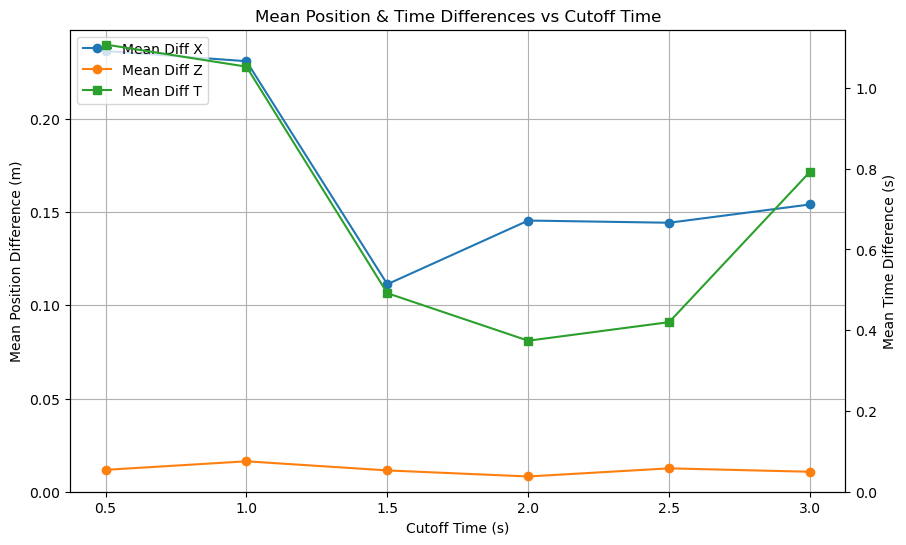

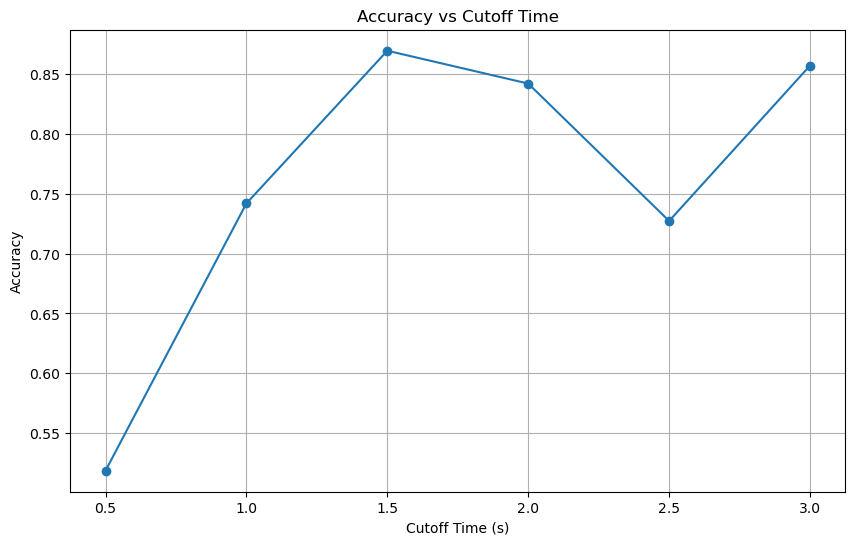

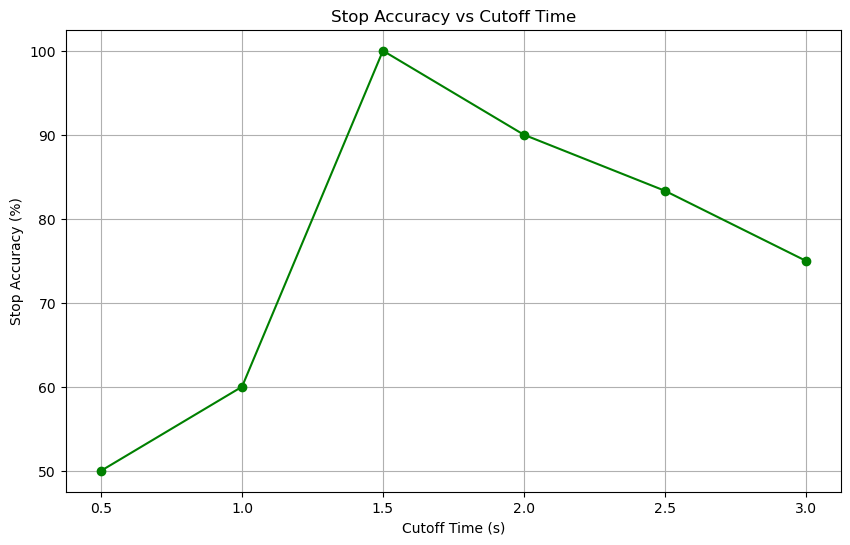

In [44]:
cutoff_times = [0.5, 1, 1.5, 2, 2.5, 3]
df_time = pd.DataFrame(columns=['cutoff_time', 'mean_diff_x', 'mean_diff_y', 'mean_diff_z', 'num_trajectories'])
conf_matrices_time = {}
all_diffs_x = []
for cutoff_time in cutoff_times:
    print(f"Evaluating Kalman Filter with cutoff time: {cutoff_time}")
    diffs, conf_mt, accuracy = evaluate_kf(dataloader, model, device, cutoff_time = cutoff_time, all_preds=all_preds)
    conf_matrices_time[cutoff_time] = conf_mt
    stop_accuracy = (diffs[:, 0] < half_size_of_robot).mean() * 100
    new_row = {
        'cutoff_time': cutoff_time,
        'mean_diff_x': diffs[:, 0].mean(),
        'mean_diff_y': diffs[:, 1].mean(),
        'mean_diff_z': diffs[:, 2].mean(),
        'mean_diff_t': diffs[:, 3].mean(),
        'accuracy': accuracy,
        'num_trajectories': len(diffs),
        'stop_accuracy': stop_accuracy
    }
    df_time = pd.concat([df_time, pd.DataFrame([new_row])], ignore_index=True)
    all_diffs_x.extend(diffs[:, 0])
    print('-'*50)
print(df_time)

# # Plot mean diff x
# plt.figure(figsize=(10, 6))
# plt.plot(df_time['cutoff_time'], df_time['mean_diff_x'], marker='o', label='Mean Diff X')
# # plt.plot(df_time['cutoff_time'], df_time['mean_diff_y'], marker='o', label='Mean Diff Y')
# plt.plot(df_time['cutoff_time'], df_time['mean_diff_z'], marker='o', label='Mean Diff Z')
# plt.title('Mean Position Differences vs Cutoff Time')
# plt.xlabel('Cutoff Time (s)')
# plt.ylabel('Mean Position Difference (m)')
# plt.legend()
# plt.grid()

# Plot mean diff_x and t
fig, ax1 = plt.subplots(figsize=(10, 6))
x = df_time['cutoff_time']
y1 = df_time['mean_diff_x']
y3 = df_time['mean_diff_z']
yt = df_time['mean_diff_t']
# Left axis: spatial differences
ax1.plot(x, y1, marker='o', label='Mean Diff X')
# ax1.plot(x, df_time['mean_diff_y'], marker='o', label='Mean Diff Y')
ax1.plot(x, y3, marker='o', label='Mean Diff Z')
ax1.set_xlabel('Cutoff Time (s)')
ax1.set_ylabel('Mean Position Difference (m)')
ax1.grid(True)
ax1.set_ylim(bottom=0)  # Set y-axis to start from 0
# Twin axis for time difference
ax2 = ax1.twinx()
ax2.plot(x, yt, marker='s', color='tab:green', label='Mean Diff T')
ax2.set_ylabel('Mean Time Difference (s)')
ax2.set_ylim(bottom=0)  # Set y-axis to start from 0
# Combine legends
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left')
plt.title('Mean Position & Time Differences vs Cutoff Time')
plt.show()

# Plot accuracy
plt.figure(figsize=(10, 6))
plt.plot(df_time['cutoff_time'], df_time['accuracy'], marker='o', label='Accuracy')
plt.title('Accuracy vs Cutoff Time')
plt.xlabel('Cutoff Time (s)')
plt.ylabel('Accuracy')
plt.grid()

# Plot stop accuracy
plt.figure(figsize=(10, 6))
plt.plot(df_time['cutoff_time'], df_time['stop_accuracy'], marker='o', label='Stop Accuracy', color = 'green')
plt.title('Stop Accuracy vs Cutoff Time')
plt.xlabel('Cutoff Time (s)')
plt.ylabel('Stop Accuracy (%)')
plt.grid()

## Evaluating plus 0.5


Evaluating Kalman Filter with cutoff distance: 3
Using cutoff distance: 3 meters.
Using time prediction: 0.3 seconds.


Evaluating Kalman Filter: 100%|██████████| 87/87 [00:01<00:00, 54.11it/s]
C:\Users\realenriquem\AppData\Local\Temp\ipykernel_12908\2558559889.py:16: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_distances = pd.concat([df_distances, pd.DataFrame([new_row])], ignore_index=True)


--------------------------------------------------
Evaluating Kalman Filter with cutoff distance: 4
Using cutoff distance: 4 meters.
Using time prediction: 0.3 seconds.


Evaluating Kalman Filter: 100%|██████████| 87/87 [00:01<00:00, 58.38it/s]


--------------------------------------------------
Evaluating Kalman Filter with cutoff distance: 5
Using cutoff distance: 5 meters.
Using time prediction: 0.3 seconds.


Evaluating Kalman Filter: 100%|██████████| 87/87 [00:01<00:00, 60.78it/s]


--------------------------------------------------
Evaluating Kalman Filter with cutoff distance: 6
Using cutoff distance: 6 meters.
Using time prediction: 0.3 seconds.


Evaluating Kalman Filter: 100%|██████████| 87/87 [00:01<00:00, 64.68it/s]


--------------------------------------------------
Evaluating Kalman Filter with cutoff distance: 7
Using cutoff distance: 7 meters.
Using time prediction: 0.3 seconds.


Evaluating Kalman Filter: 100%|██████████| 87/87 [00:01<00:00, 72.06it/s]


--------------------------------------------------
Evaluating Kalman Filter with cutoff distance: 8
Using cutoff distance: 8 meters.
Using time prediction: 0.3 seconds.


Evaluating Kalman Filter: 100%|██████████| 87/87 [00:01<00:00, 74.25it/s]


--------------------------------------------------
Evaluating Kalman Filter with cutoff distance: 9
Using cutoff distance: 9 meters.
Using time prediction: 0.3 seconds.


Evaluating Kalman Filter: 100%|██████████| 87/87 [00:01<00:00, 77.38it/s]


--------------------------------------------------
Evaluating Kalman Filter with cutoff distance: 10
Using cutoff distance: 10 meters.
Using time prediction: 0.3 seconds.


Evaluating Kalman Filter: 100%|██████████| 87/87 [00:01<00:00, 83.54it/s]

--------------------------------------------------
  cutoff_distance  mean_diff_x  mean_diff_y  mean_diff_z  norm_diff  \
0               3     0.368380     1.825843     0.097000   1.922880   
1               4     0.311836     1.597493     0.062015   1.664126   
2               5     0.489999     2.303741     0.050376   2.385959   
3               6     0.648069     3.443861     0.052109   3.596946   
4               7     0.735262     5.122375     0.063371   5.228522   
5               8     0.984064     4.186317     0.088069   4.516378   
6               9     1.698879     9.959149     0.098444  10.340815   
7              10     6.671928    15.957361     0.060337  19.201801   

   num_trajectories  
0              15.0  
1              26.0  
2              34.0  
3              43.0  
4              37.0  
5              37.0  
6              27.0  
7              17.0  


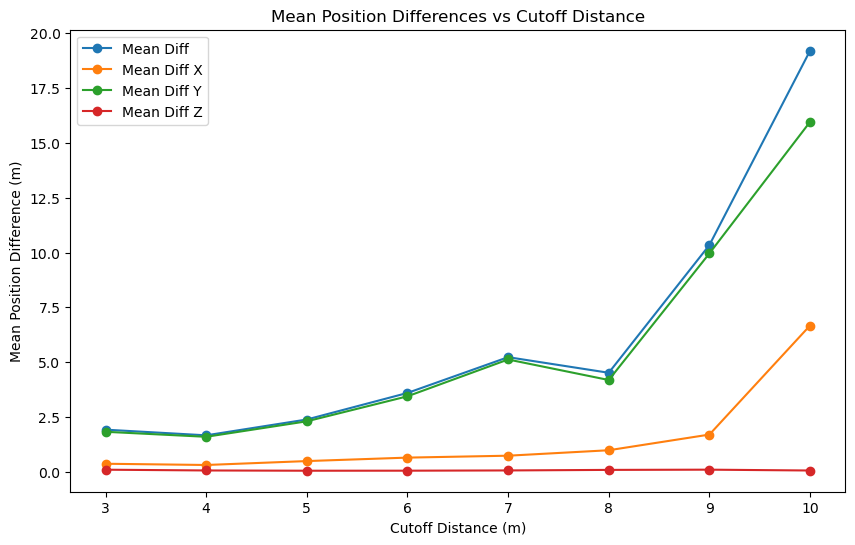

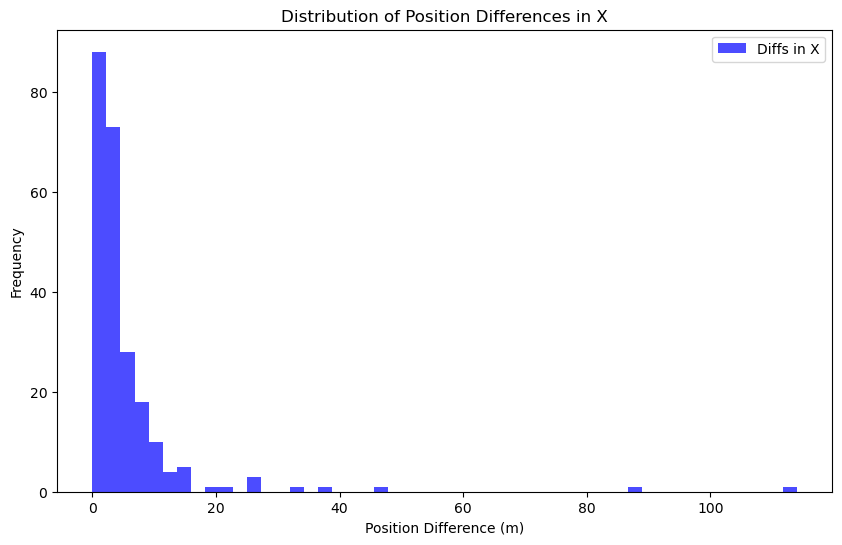

In [ ]:
cutoff_distances = [3, 4, 5, 6, 7, 8, 9, 10]
df_distances = pd.DataFrame(columns=['cutoff_distance', 'mean_diff_x', 'mean_diff_y', 'mean_diff_z'])
time_pred = 0.3
all_norm_diffs = []
for cutoff_distance in cutoff_distances:
    print(f"Evaluating Kalman Filter with cutoff distance: {cutoff_distance}")
    diffs, _, _ = evaluate_kf(dataloader, model, device, cutoff_distance = cutoff_distance, all_preds=all_preds, time_pred=time_pred, check_result='time')
    new_row = {
        'cutoff_distance': cutoff_distance,
        'mean_diff_x': diffs[:, 0].mean(),
        'mean_diff_y': diffs[:, 1].mean(),
        'mean_diff_z': diffs[:, 2].mean(),
        'norm_diff': np.linalg.norm(diffs, axis=1).mean(),
        'num_trajectories': len(diffs)
    }
    df_distances = pd.concat([df_distances, pd.DataFrame([new_row])], ignore_index=True)
    print('-'*50)
    all_norm_diffs.extend(np.linalg.norm(diffs, axis=1))
print(df_distances)

# Plot mean abs diff
plt.figure(figsize=(10, 6))
plt.plot(df_distances['cutoff_distance'], df_distances['norm_diff'], marker='o', label='Mean Diff')
plt.plot(df_distances['cutoff_distance'], df_distances['mean_diff_x'], marker='o', label='Mean Diff X')
plt.plot(df_distances['cutoff_distance'], df_distances['mean_diff_y'], marker='o', label='Mean Diff Y')
plt.plot(df_distances['cutoff_distance'], df_distances['mean_diff_z'], marker='o', label='Mean Diff Z')
plt.title('Mean Position Differences vs Cutoff Distance')
plt.xlabel('Cutoff Distance (m)')
plt.ylabel('Mean Position Difference (m)')
plt.legend()

# Plot distribution of diffs in X
plt.figure(figsize=(10, 6))
plt.hist(all_norm_diffs, bins=50, alpha=0.7, color='blue', label='Diffs in X')
plt.title('Distribution of Position Differences in X')
plt.xlabel('Position Difference (m)')
plt.ylabel('Frequency')
plt.legend()

Evaluating Kalman Filter with cutoff time: 0.2
Using cutoff time: 0.2 seconds.
Using time prediction: 0.3 seconds.


Evaluating Kalman Filter: 100%|██████████| 87/87 [00:01<00:00, 68.34it/s]
C:\Users\realenriquem\AppData\Local\Temp\ipykernel_12908\2770305134.py:16: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_time = pd.concat([df_time, pd.DataFrame([new_row])], ignore_index=True)


--------------------------------------------------
Evaluating Kalman Filter with cutoff time: 0.5
Using cutoff time: 0.5 seconds.
Using time prediction: 0.3 seconds.


Evaluating Kalman Filter: 100%|██████████| 87/87 [00:01<00:00, 63.64it/s]


--------------------------------------------------
Evaluating Kalman Filter with cutoff time: 1
Using cutoff time: 1 seconds.
Using time prediction: 0.3 seconds.


Evaluating Kalman Filter: 100%|██████████| 87/87 [00:01<00:00, 69.22it/s]


--------------------------------------------------
Evaluating Kalman Filter with cutoff time: 1.5
Using cutoff time: 1.5 seconds.
Using time prediction: 0.3 seconds.


Evaluating Kalman Filter: 100%|██████████| 87/87 [00:01<00:00, 68.80it/s]


--------------------------------------------------
Evaluating Kalman Filter with cutoff time: 2
Using cutoff time: 2 seconds.
Using time prediction: 0.3 seconds.


Evaluating Kalman Filter: 100%|██████████| 87/87 [00:01<00:00, 70.42it/s]


--------------------------------------------------
Evaluating Kalman Filter with cutoff time: 2.5
Using cutoff time: 2.5 seconds.
Using time prediction: 0.3 seconds.


Evaluating Kalman Filter: 100%|██████████| 87/87 [00:01<00:00, 78.17it/s]


--------------------------------------------------
Evaluating Kalman Filter with cutoff time: 3
Using cutoff time: 3 seconds.
Using time prediction: 0.3 seconds.


Evaluating Kalman Filter: 100%|██████████| 87/87 [00:01<00:00, 80.64it/s]

--------------------------------------------------
   cutoff_time  mean_diff_x  mean_diff_y  mean_diff_z  norm_diff  \
0          0.2     3.468132    13.097610     0.054933  13.868428   
1          0.5     1.429333     6.588324     0.057047   6.864304   
2          1.0     0.571919     2.999320     0.022843   3.123963   
3          1.5     0.486882     2.340554     0.017292   2.427271   
4          2.0     0.340979     2.054692     0.020781   2.098345   
5          2.5     0.259504     1.198355     0.017961   1.306589   
6          3.0     0.248927     1.936453     0.019961   1.965676   

   num_trajectories  
0              59.0  
1              44.0  
2              37.0  
3              29.0  
4              18.0  
5              10.0  
6               6.0  


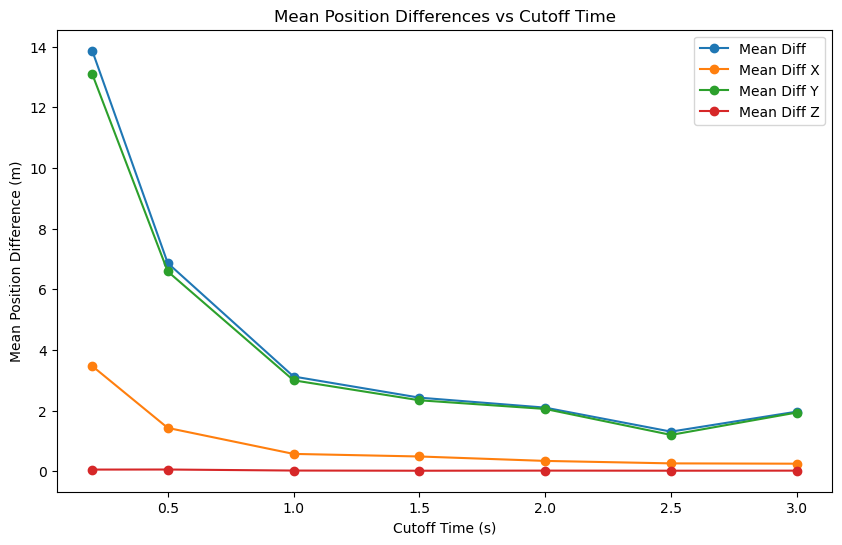

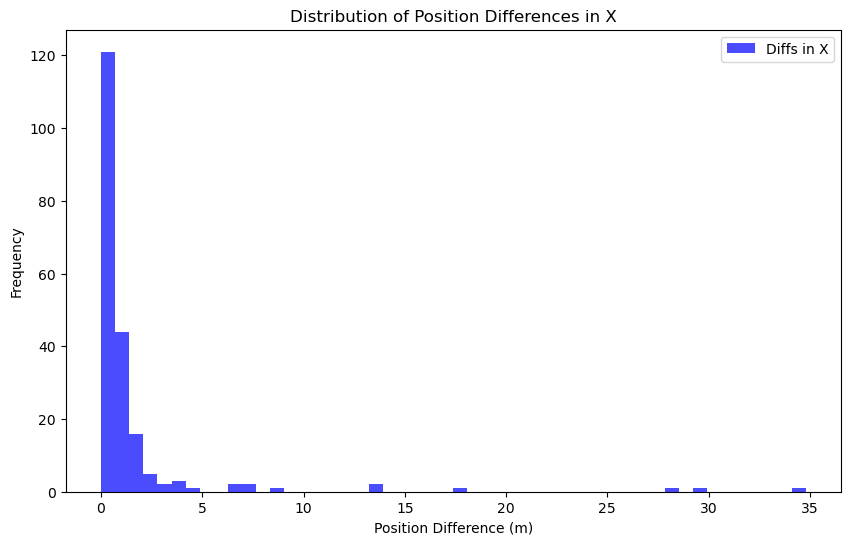

In [ ]:
cutoff_times = [0.2, 0.5, 1, 1.5, 2, 2.5, 3]
df_time = pd.DataFrame(columns=['cutoff_time', 'mean_diff_x', 'mean_diff_y', 'mean_diff_z'])
time_pred = 0.3
all_diffs_x = []
for cutoff_time in cutoff_times:
    print(f"Evaluating Kalman Filter with cutoff time: {cutoff_time}")
    diffs, _, _ = evaluate_kf(dataloader, model, device, cutoff_time = cutoff_time, all_preds=all_preds, check_result='time', time_pred=time_pred)
    new_row = {
        'cutoff_time': cutoff_time,
        'mean_diff_x': diffs[:, 0].mean(),
        'mean_diff_y': diffs[:, 1].mean(),
        'mean_diff_z': diffs[:, 2].mean(),
        'norm_diff': np.linalg.norm(diffs, axis=1).mean(),
        'num_trajectories': len(diffs)
    }
    df_time = pd.concat([df_time, pd.DataFrame([new_row])], ignore_index=True)
    all_diffs_x.extend(diffs[:, 0])
    print('-'*50)
print(df_time)

# Plot mean abs diff
plt.figure(figsize=(10, 6))
plt.plot(df_time['cutoff_time'], df_time['norm_diff'], marker='o', label='Mean Diff')
plt.plot(df_time['cutoff_time'], df_time['mean_diff_x'], marker='o', label='Mean Diff X')
plt.plot(df_time['cutoff_time'], df_time['mean_diff_y'], marker='o', label='Mean Diff Y')
plt.plot(df_time['cutoff_time'], df_time['mean_diff_z'], marker='o', label='Mean Diff Z')
plt.title('Mean Position Differences vs Cutoff Time')
plt.xlabel('Cutoff Time (s)')
plt.ylabel('Mean Position Difference (m)')
plt.legend()

# Plot distribution of diffs in X
plt.figure(figsize=(10, 6))
plt.hist(all_diffs_x, bins=50, alpha=0.7, color='blue', label='Diffs in X')
plt.title('Distribution of Position Differences in X')
plt.xlabel('Position Difference (m)')
plt.ylabel('Frequency')
plt.legend()

In [ ]:
len(all_norm_diffs)

386

Using cutoff distance: 5 meters.
Using goal prediction.


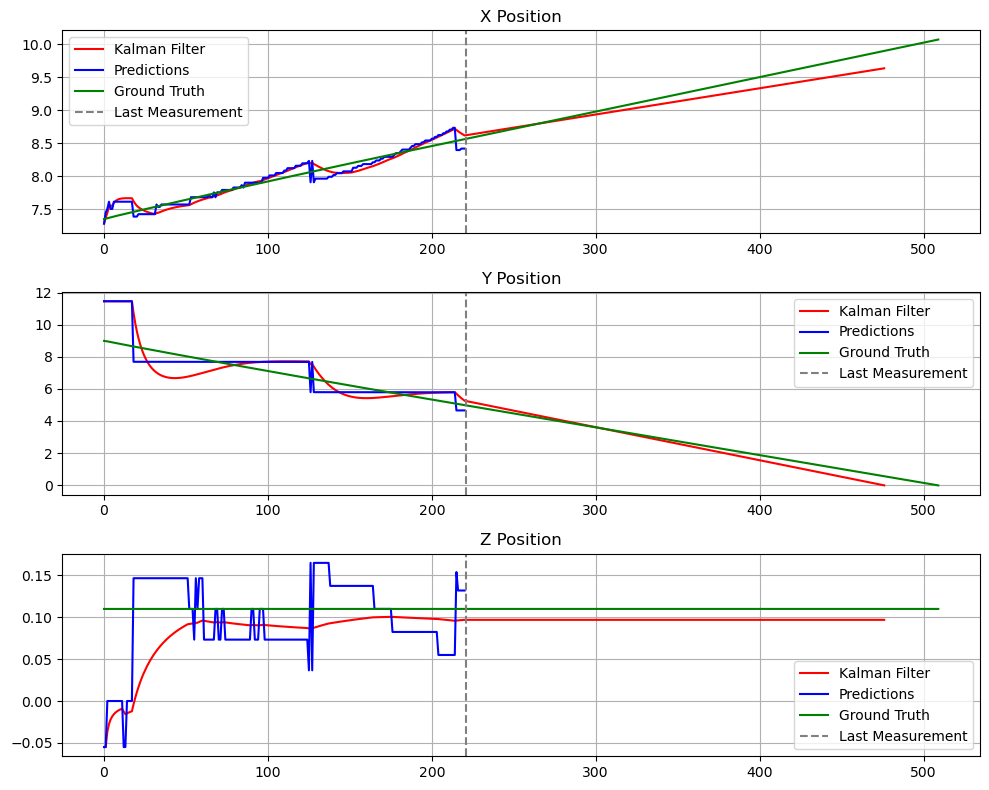

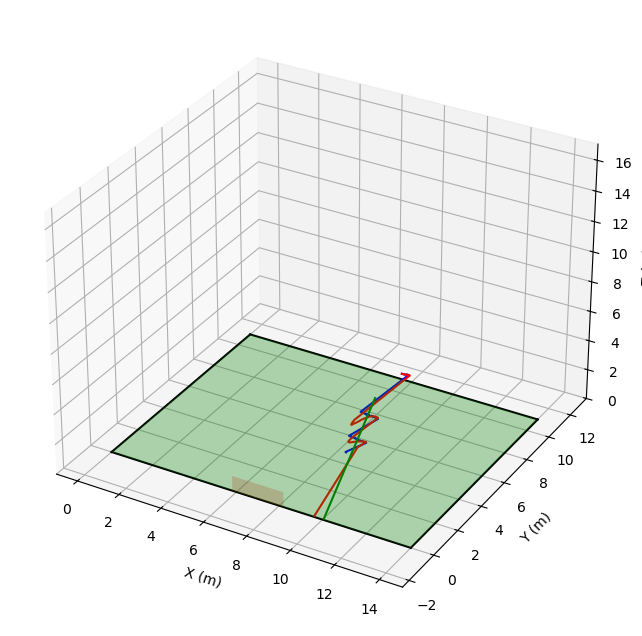

Video saved to kf_output.avi


In [ ]:
cutoff_distance = 5
print_kf(dataloader, model, device, cutoff_distance = cutoff_distance, all_preds=all_preds, check_result='goal', identifier='', ground_truth=True, gen_video=True)

In [ ]:
point = np.array([7, 4, 1])
print(CAMERA.project_point(point))
CAMERA.project_point_old(point)


(array([647, 167]), np.float64(3.8554294102780142))


(array([647, 167]), np.float64(3.8554294102780142))

Using cutoff time: 0.75 seconds.
Using goal prediction.


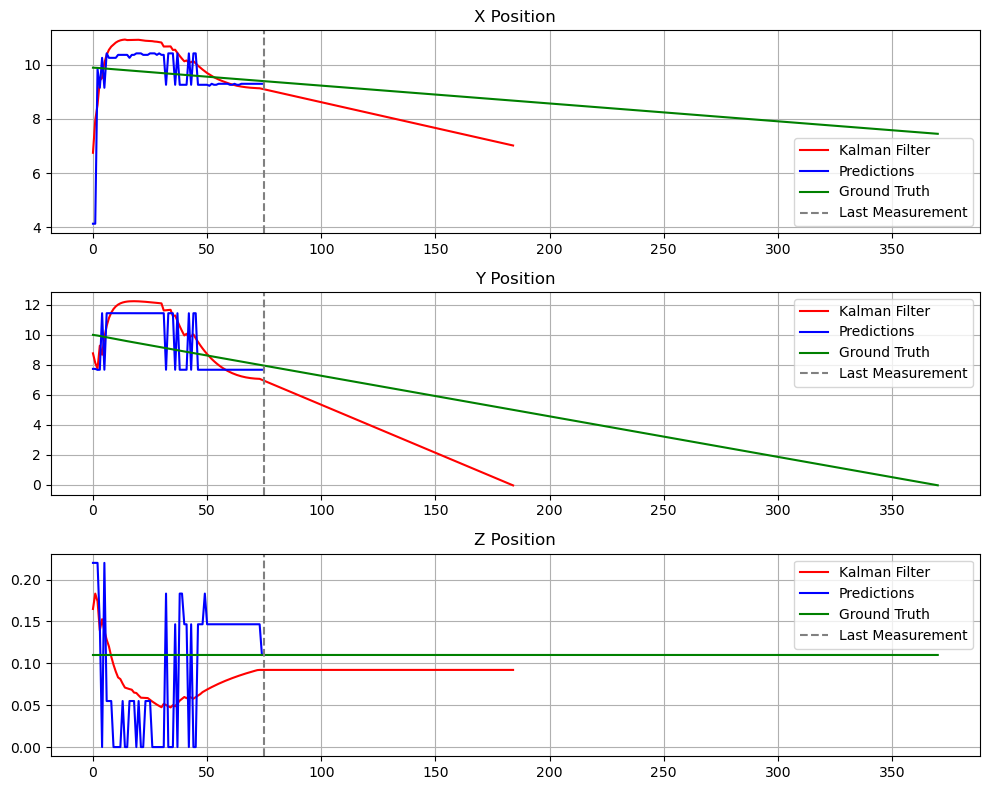

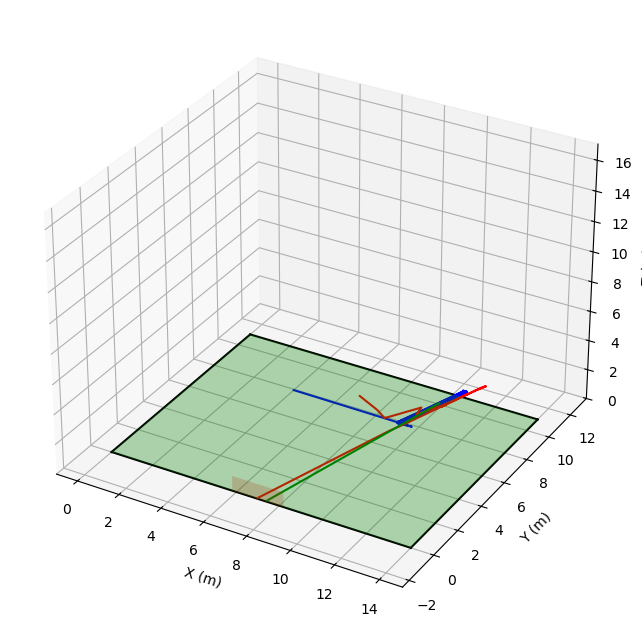

In [ ]:
cutoff_time = 0.75
print_kf(dataloader, model, device, cutoff_time = cutoff_time, all_preds=all_preds, check_result='goal', ground_truth=True)

Using cutoff distance: 5 meters.
Using time prediction: 0.3 seconds.


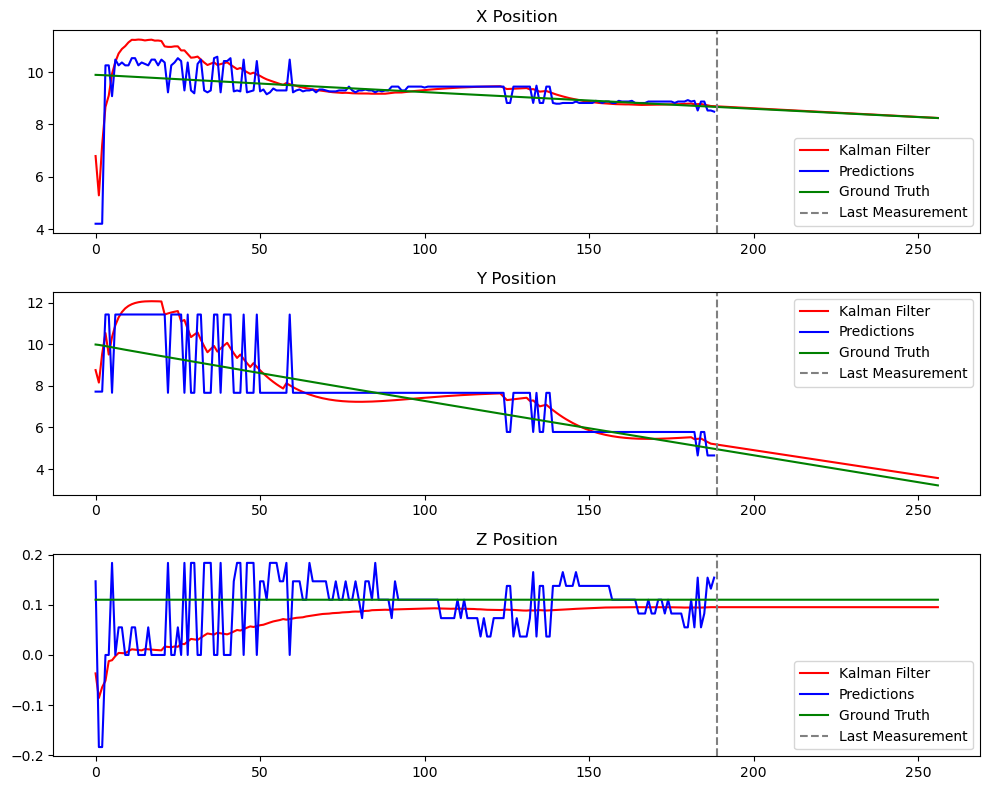

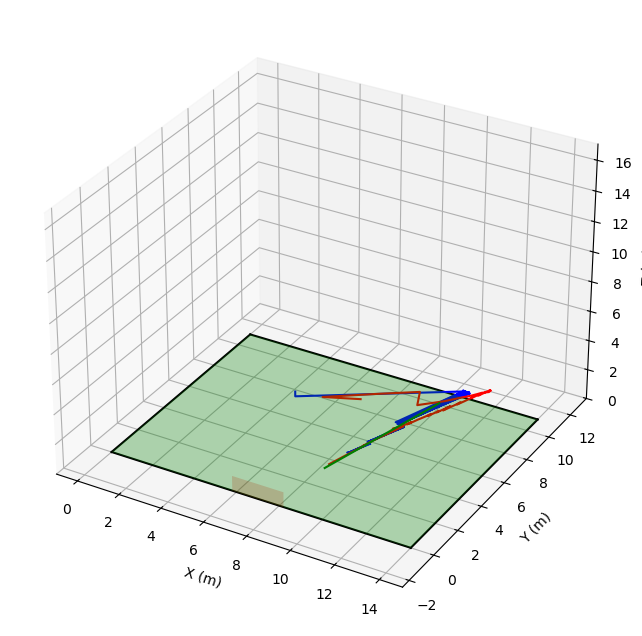

In [ ]:
cutoff_distance = 5
time_pred = 0.3
print_kf(dataloader, model, device, cutoff_distance = cutoff_distance, all_preds=all_preds, time_pred=time_pred, check_result='time', ground_truth=True)

Using cutoff time: 1 seconds.
Using time prediction: 0.3 seconds.


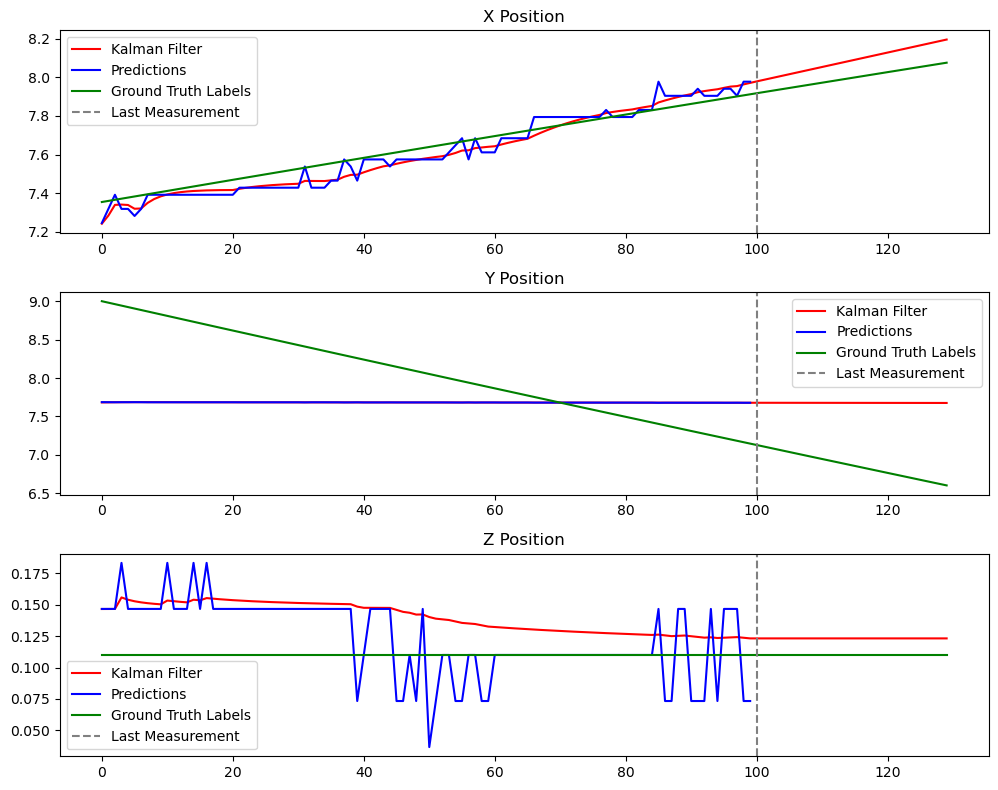

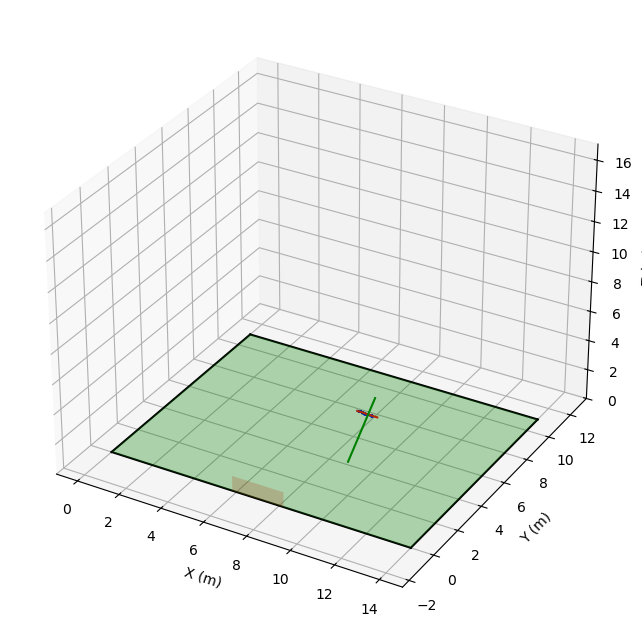

In [ ]:
cutoff_time = 1
time_pred = 0.3
print_kf(dataloader, model, device, cutoff_time = cutoff_time, all_preds=all_preds, check_result='time', time_pred=time_pred, ground_truth=True)

# Now lets try to make the KF prediction better

In [ ]:
def error_R(R):
    a = 1.0095
    b = -0.5225
    return a*R + b

def calculate_pixel_real_world_size(focal_length, distance):
    """
    Calculate the real-world size represented by one pixel in a pinhole camera model.

    Parameters:
    sensor_width (float): Physical width of the camera sensor in meters.
    image_width (int): Number of pixels in the image width.
    focal_length (float): Focal length of the camera in meters.
    distance (float): Distance to the object in meters.

    Returns:
    float: Real-world size per pixel in meters.
    """
    real_size_per_pixel = (distance / focal_length)
    return real_size_per_pixel

def get_depth(focal_length, ball_radius_world, radius_pixels):
        """
        Given the ball radius in world coordinates and the projected radius in pixels,
        compute the depth of the ball in camera coordinates.
        """
        return focal_length * (ball_radius_world / radius_pixels)

Evaluating video classification tracker
Error 0: μ=1.31, σ=6.05, 95% CI=11.257 pixels
Error 1: μ=0.98, σ=3.97, 95% CI=7.510 pixels
Error 2: μ=0.45, σ=1.63, 95% CI=3.134 pixels
Total errors: σ=5.38, 95% CI=13.170 pixels


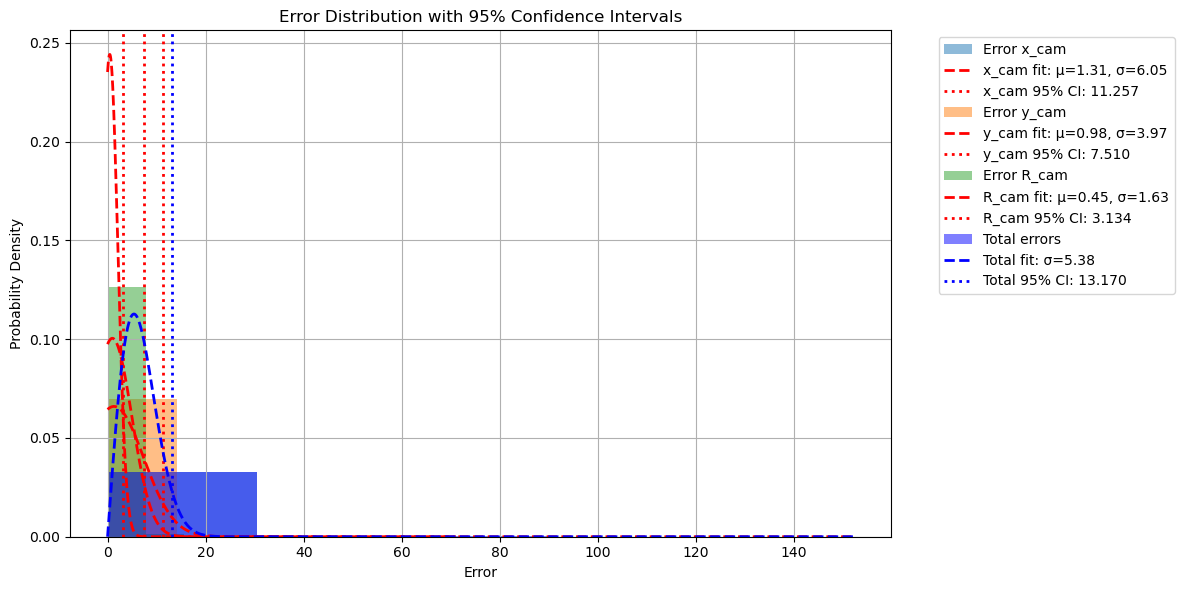

In [ ]:
model.evaluate(dataloader, device, num_steps=4, print_results=True, operation='distribution')

In [7]:
all_preds_eval, all_gts = model.evaluate(dataloader, device, num_steps=4, print_results=True, operation='preds')

Evaluating video classification tracker


In [ ]:
camera_errors = np.abs(all_preds_eval - all_gts)
camera_errors

array([[3, 0, 0, ..., 1, 1, 2],
       [1, 1, 0, ..., 4, 5, 5],
       [0, 0, 0, ..., 1, 1, 1]])

In [8]:
world_preds, world_gts = project_to_world(all_preds_eval, dataset, torch.tensor(all_gts))

In [9]:
world_errors = np.abs(world_preds - world_gts)
world_errors = world_errors.transpose(1, 0)
world_preds = world_preds.transpose(1, 0)
world_errors.shape

(3, 11634)

In [10]:
cov_matrix = np.cov(world_errors, rowvar=True, ddof=1)
cov_matrix

array([[0.10178748, 0.29141015, 0.02153598],
       [0.29141015, 2.02234148, 0.16629704],
       [0.02153598, 0.16629704, 0.02789475]])

In [126]:
cov_matrix.shape

(3, 3)

In [ ]:
absolute_errors = np.linalg.norm(errors, axis=0)
absolute_errors.shape

(11634,)

Linear model:  error = -0.0029·GT + 0.1196
R² (linear): 0.0004082772221664088


Text(0.5, 1.0, 'Linear Regression Fit')

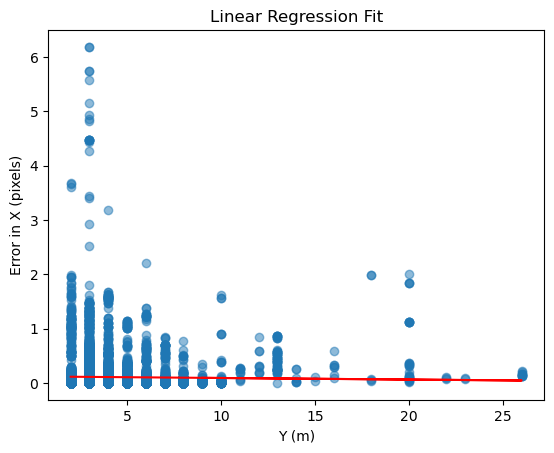

In [120]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

x = all_preds[2].reshape(-1, 1)  # Radius in pixels
y = world_errors[0]

# 2a. Fit a simple linear regression
lin_reg = LinearRegression()
lin_reg.fit(x, y)
y_pred_lin = lin_reg.predict(x)

print(f"Linear model:  error = {lin_reg.coef_[0]:.4f}·GT + {lin_reg.intercept_:.4f}")
print("R² (linear):", r2_score(y, y_pred_lin))

plt.scatter(x, y, alpha=0.5)
plt.xlabel('Y (m)')
plt.ylabel('Error in X (pixels)')
plt.plot(x, y_pred_lin, color='red', label='Linear Fit')
plt.title('Linear Regression Fit')

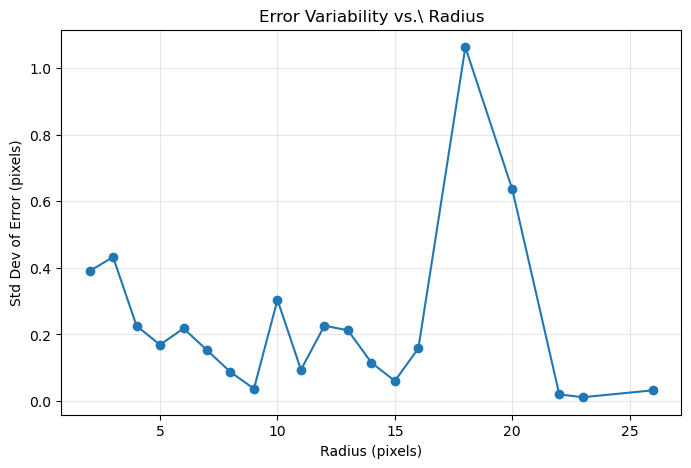

In [121]:

# Assume all_preds[2] is a 1D array of radii (in pixels),
# and world_errors[0] is the corresponding 1D array of errors.
radii = all_preds[2].ravel()
errors = world_errors[0]

# Find all the unique radius values
unique_radii = np.unique(radii)

# Compute the std of the errors for each unique radius
std_errors = np.array([errors[radii == r].std(ddof=1)  for r in unique_radii])

# Now plot radius vs. std(error)
plt.figure(figsize=(8,5))
plt.plot(unique_radii, std_errors, marker='o', linestyle='-')
plt.xlabel('Radius (pixels)')
plt.ylabel('Std Dev of Error (pixels)')
plt.title('Error Variability vs.\ Radius')
plt.grid(alpha=0.3)
plt.show()

In [105]:
y

array([1.84541151e-03, 1.36356057e-06, 8.81641908e-07, ...,
       2.52318589e-01, 2.52318589e-01, 2.52195326e-01])

In [11]:
delta_t = 0.01
process_var_vel_xy = 0.1
process_var_vel_z  = 0.1
meas_var_pos       = cov_matrix

def evaluate_kf(dataloader, model, device, KFClass = None, cutoff_time = None, cutoff_distance = None, time_pred = None, all_preds=None, check_result='goal'):
    """
    Evaluate Kalman Filter positions for all videos in the dataloader.
    Returns an array of differences between predicted and ground truth positions, and a confusion matrix.
    Trajectories that go "out" of the goal are skipped in the differences calculation.
    dataset = dataloader.dataset
    """

    if cutoff_time is None and cutoff_distance is None:
        print("No cutoff specified, looking at all positions.")
    elif cutoff_time is not None and cutoff_distance is not None:
        raise ValueError("Specify either cutoff_time or cutoff_distance, not both.")
    elif cutoff_time is not None:
        print(f"Using cutoff time: {cutoff_time} seconds.")
        cutoff_type = 'time'
    elif cutoff_distance is not None:
        print(f"Using cutoff distance: {cutoff_distance} meters.")
        cutoff_type = 'distance'
    
    if check_result == 'time':
        if time_pred is None:
            raise ValueError("If check_result is 'time', time_pred must be specified.")
        elif time_pred is not None:
            print(f"Using time prediction: {time_pred} seconds.")
    elif check_result == 'goal':
        if time_pred is not None:
            print(f"WARNING: time_pred is ignored when check_result is 'goal'.")
        else:
            print("Using goal prediction.")
    else:
        raise ValueError("check_result must be either 'goal' or 'time'.")
    

    dataset = dataloader.dataset
    N = len(dataset)
    diffs = []

    # Prepare confusion matrix
    classes = ["in", "out"]
    conf_mat = np.zeros((2,2), dtype=int)

    if all_preds is None: all_preds = network.get_preds_all_videos(model, dataloader, device=device, num_steps=model.training_params['num_steps'])
    for idx in tqdm(range(N), desc="Evaluating Kalman Filter"):
        _, labels, _ = dataset.__getitem__(idx)
        tr = dataset.__gettr__(idx)
        # Get predictions
        preds = all_preds[idx]
        labels = labels.transpose(0, 1)

        # Get ground truth
        _, gt_labels, _ = dataset_world.__getitemtr__(tr)
        gt_labels = gt_labels.cpu().numpy()
        pred_pos, _ = project_to_world(preds, dataset)
        N = len(pred_pos)

        if cutoff_type == "time":
            last_measurement_ts = int(cutoff_time/delta_t)
            if last_measurement_ts > N:
                # print(f"Skipping trajectory {tr} due to insufficient measurements.")
                continue
        elif cutoff_type == "distance":
            # Calculate the last measurement based on the Y position
            y_positions = gt_labels[:, 1]
            excluded_preds = np.where(y_positions < cutoff_distance)
            # print(y_positions[0])
            # print(len(excluded_preds[0]), N, len(y_positions))
            if len(excluded_preds[0]) == len(y_positions):
                # print(f"Skipping trajectory {tr} due to no measurements within cutoff distance.")
                continue
            elif len(excluded_preds[0]) == 0:
                # print(f"Skipping trajectory {tr} due to not getting to cutoff distance.")
                # continue
                last_measurement_ts = N
            else:
                last_measurement_ts = excluded_preds[0][0]

        # print(f"Last measurement timestamp: {last_measurement_ts}, Total timesteps: {N}")
        
        if KFClass is None:
            kf_preds, kf_pred_positions, pred_regime = majority_regime(pred_pos, last_measurement_ts=last_measurement_ts)

            KFClass = RollKF if pred_regime == 'roll' else ThrowKF
        else:
            kf_preds = KFClass(delta_t, process_var_vel_xy, meas_var_pos)
            kf_preds, kf_pred_positions = kalman_loop_in_fov(kf_preds, pred_pos, gt_labels, last_measurement_ts)
            
        kf_truth = KFClass(delta_t, process_var_vel_xy, meas_var_pos)

        kf_truth, truth_positions = kalman_loop_in_fov(kf_truth, gt_labels, gt_labels, last_measurement_ts)

        # print(f"Predicted positions shape: {len(kf_pred_positions)}")
        # print(f"Ground truth positions shape: {len(truth_positions)}")

        if check_result == 'goal':
            kf_preds, kf_pred_positions = predict_until_goal(kf_preds, kf_pred_positions)
            kf_truth, truth_positions = predict_until_goal(kf_truth, truth_positions)
            if kf_pred_positions is None or truth_positions is None:
                # print(f"Skipping trajectory {tr} due to insufficient measurements for goal prediction.")
                continue
        elif check_result == 'time':
            timesteps_pred = int(time_pred / delta_t)
            # print(f"Predicting until {timesteps_pred} timesteps after the last measurement.")
            # print(f"Last measurement timestamp: {last_measurement_ts}, Total timesteps: {last_measurement_ts + timesteps_pred}")
            if last_measurement_ts + timesteps_pred > len(gt_labels):
                # print(f"Skipping trajectory {tr} due to insufficient measurements for time prediction.")
                continue
            kf_preds, kf_pred_positions = predict_until_time(kf_preds, kf_pred_positions, timesteps_pred)
            kf_truth, truth_positions = predict_until_time(kf_truth, truth_positions, timesteps_pred)
            
        kf_pred_positions = np.array(kf_pred_positions)
        # print(f"Predicted positions shape: {kf_pred_positions.shape}")
        truth_positions = np.array(truth_positions)
        # print(f"Ground truth positions shape: {truth_positions.shape}")
        
        final_prediction = kf_pred_positions[-1]
        final_true_position = truth_positions[-1]


        if check_result == 'goal':
            pred_type, gt_type = get_traj_type(final_prediction, dataset, tr, FIELD)

            # 1) Record confusion for *all* trajectories
            i = classes.index(gt_type)
            j = classes.index(pred_type)
            conf_mat[i, j] += 1

            # if pred_type == 'in' and gt_type == 'in':

            # Here record the results in a 3x3 confusion matrix ("in", "almost_in", "out")

            if pred_type == 'out' or gt_type == 'out':
                continue

        # print(f"Position in goal: {position_in_goal}, Truth in goal: {truth_in_goal}")
        
        # Add the timestamp to the final positions
        final_prediction = np.append(final_prediction, len(kf_pred_positions)*delta_t)
        final_true_position = np.append(final_true_position, len(truth_positions)*delta_t)

        diffs.append([abs(final_prediction[k] - final_true_position[k]) for k in range(len(final_prediction))])
        # diffs.append([final_prediction[k] - final_true_position[k] for k in range(len(final_prediction))])
        # 7) Delete everything large before next iteration
        # del preds, kf_pred_positions, truth_positions
        del final_prediction, final_true_position, pred_pos, gt_labels
        del preds, labels, kf_pred_positions, truth_positions, kf_preds, kf_truth
        torch.cuda.empty_cache()
        # break

    diffs = np.array(diffs, dtype=np.float32)
    # print_kf_graph(kf_pred_positions, truth_positions, pred_pos, gt_labels, last_measurement_ts)
    if check_result == 'goal':
        conf_df = pd.DataFrame(
            conf_mat,
            index=[f"True_{c}" for c in classes],
            columns=[f"Pred_{c}" for c in classes]
        )

        print("\nConfusion matrix:")
        print(conf_df)
        acc = np.trace(conf_mat) / conf_mat.sum()
        print(f"\nOverall accuracy: {acc:.3f}")
        return diffs, conf_mat, acc
    else:
        return diffs, None, None

In [59]:
tr = 7
video, labels, length = dataset.__getitemtr__(tr)
gen = dt.image_gen_for_video(video, labels)



720 1280
max tensor(1.)
min tensor(0.)
Label:  tensor([429.3654, 246.6715,  89.5655])


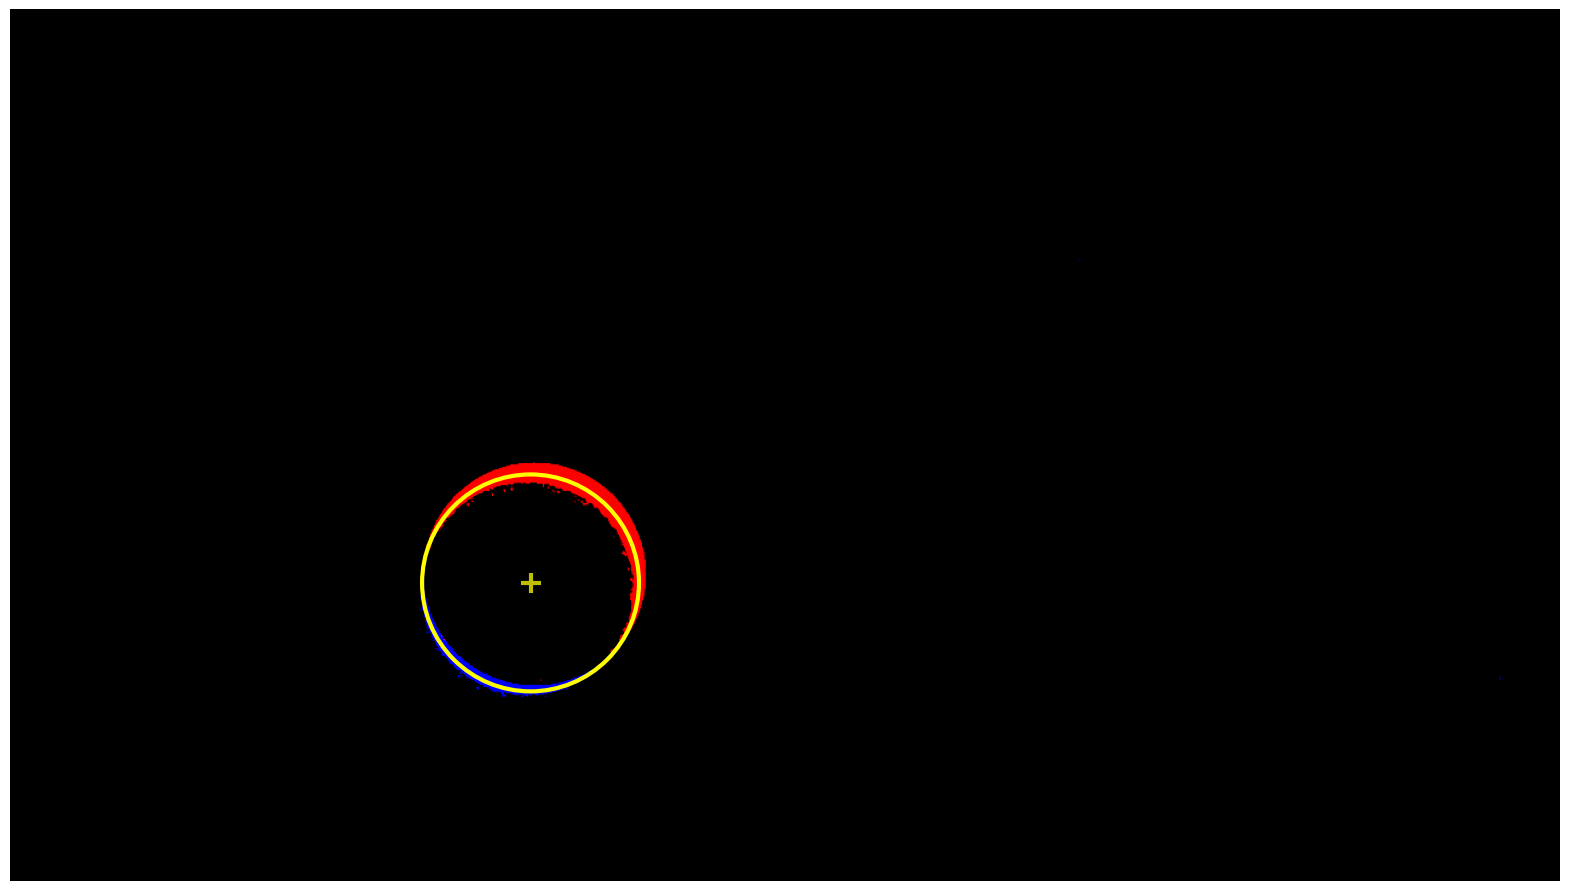

In [71]:
dt.show_next_img(gen, show_labels=True, just_image=True)

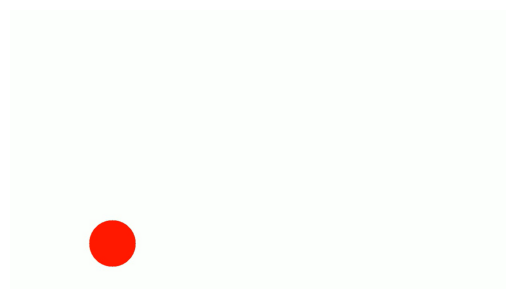

In [16]:
import cv2
import matplotlib.pyplot as plt

# Load video and extract frame at minute 1 (60000 ms)
video_path = r"C:\Users\realenriquem\OneDrive - Sioux Group B.V\Documents\Git\BallTrackingSNN\dataset_python_sim2\rgb\tr1.mp4"
cap = cv2.VideoCapture(video_path)
cap.set(cv2.CAP_PROP_POS_MSEC, 300)

ret, frame = cap.read()
cap.release()

if ret:
    # Convert BGR (OpenCV format) to RGB (Matplotlib format)
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    # Show the frame using matplotlib
    plt.imshow(frame_rgb)
    # plt.title("Frame at 1 minute")
    plt.axis('off')  # Hide axis ticks
    plt.show()
else:
    print("Failed to read frame at 1 minute.")
